# Exploring Seeing Double FFNN Dynamics

#### Overall Idea: Track the evolution of certain attractors with respect to changes in $\rho$. It's then possible to assemble a bifurcation picture of the RCs dynamics as $\rho$ changes.

### Initialize: Import Libraries, Specify Parameters, Import Fly Model, Create Reservoir

In [2]:
# imports
import numpy as np
import numpy.linalg as npl
from numpy.linalg import inv
from numpy import random
import scipy as scipy
import scipy.sparse as sparse
from scipy.sparse import diags
from scipy.sparse.linalg import eigs
from scipy.linalg import sqrtm
from scipy.sparse import identity
from scipy.sparse import vstack
from multiprocessing import Pool
from functools import partial
from MAIN_22 import generate_M,generate_Win,Big_listen_stage,Big_train_stage,predict_stage,generate_NetOut
from MAIN_22 import Generate_predicitons,Generate_MF_predicitons,Generate_training_data,BlendingTechnique
from LCsys_11 import LCsys
from Circle_error_tools import Error_analysis_of_Pred_Circle,test_Error_analysis_of_Pred_Circle
from Circle_error_tools import check_errmaxminCA,check_errmaxminCB, fix_length_of_maxmins_with_nans
from Circle_error_tools import estimate_circ_center,direction_of_rotation_stricter,roundness
from Circle_error_tools import list_to_check_if_LC
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
from PlotTools import make_hist, make_hist_ev
from IPython.core.debugger import set_trace

# time constants for integration
dt = 0.01 #time step
Tlisten = 37.7 #Listening Time 6T
ListenEndTime = int(Tlisten/dt) #Discretised Listen Time
Ttrain = 94.25 + Tlisten #Training Time 15T
TrainEndTime = int(Ttrain/dt) #Discretised Train Time
Tpredict = 169.65 + Ttrain #1669.65 + Ttrain# #Predicting Time 27T
PredictEndTime = int(Tpredict/dt) #Discretised Predict Time
t_time = np.linspace(0.0,Tpredict,int(Tpredict/dt)) #(Total Time)
SysDim = 2 #Used in initialising Win and regression

# res params
gama = 5 # damping coefficient
sigma = 0.2 # input strength
beta = 1e-2 #Regularization Parameter
alpha = 0.5 #Blending parameter

# input data params
dd1=5
dd2=-5
omega1=1
omega2=-1

# error bounds
predtime=PredictEndTime-TrainEndTime
FP_err_lim=1e-3
sample_start=predtime-5000#+10000
sample_end=predtime-1000#+10000
stepback=20
randrange=10
pts1=250
pts2=200
pts3=150
pts4=100
FP_sample_start=predtime-1000#+10000
FP_sample_end=predtime#+10000
iter_no=1000
LC_err_tol=0.01
LC_err_tol_v3=0.00001
rounding_no=2

# import fly model
with open(f'models/LHRdiag_wtol50.npy', 'rb') as f:
    ffnn = np.load(f)

# params to investigate
N = ffnn.shape[0]  # no. of nodes - shape[0] is 426
rho=1.4 #default value
d = 0.05 #prob. of an element of M to be nonzero 
SysDim=2

# create reservoir
# first time...
# Minit = sparse.csr_matrix(np.copy(M))
# largest_evalue = np.abs(sparse.linalg.eigs(Minit, k=1, which='LM', return_eigenvectors=False))
# M = sparse.csr_matrix((rho / abs(largest_evalue[0])) * Minit)
# Win = generate_Win(N,SysDim)
# np.savetxt("MinitFFNN.txt",Minit.toarray())
# np.savetxt("WinFFNN.txt",Win.toarray())

# after first time...
Minit = np.genfromtxt("MinitFFNN.txt",unpack=True)
Minit = Minit.T
largest_evalue = sparse.linalg.eigs(Minit,k=1,which='LM',return_eigenvectors=False)
Win = np.genfromtxt("WinFFNN.txt", unpack=True)
Win = sparse.csr_matrix(Win.T)

In [3]:
def trainRC_part1(rhospace,Minit,xcen,alpha,dt,t_time,ListenEndTime,TrainEndTime,PredictEndTime,Win,largest_evalue,N,dd1,
                  omega1,dd2,omega2,gama,sigma,beta,FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol,rounding_no,
                  sample_start,sample_end,stepback,Xcen1,ycen,iter_no,Xcen2):
    print('rho','__','N','__','err_C1','__','err_C2','__','C1 rel rnd','__','C2 rel rnd','__','C1filt','__','C2filt')
    for rho in rhospace:
        M = (rho/abs(largest_evalue[0]))*Minit
        M = sparse.csr_matrix(M)     
        ##Multifunctional case
        Xpredict_1_MF,Xpredict_2_MF,Rpredictsq_1_MF,Rpredictsq_2_MF, xy_1, xy_2, r_1, r_2, Wout_alpha, NetOut_1_MF,NetOut_2_MF=Generate_MF_predicitons(rho,xcen,alpha,dt,t_time,ListenEndTime,TrainEndTime,PredictEndTime,M,Win,largest_evalue,N,dd1,omega1,dd2,omega2,gama,sigma,beta)
        xp1_C1,xp2_C1 = Xpredict_1_MF#Actual output
        xpredict1_C1_MF,xpredict2_C1_MF = NetOut_1_MF#RC prediction
        xp1_C2,xp2_C2 = Xpredict_2_MF#Actual output
        xpredict1_C2_MF,xpredict2_C2_MF = NetOut_2_MF#RC prediction
        ##Error Analysis
        #C1
        err_C1,C1_vel_dir_strict,C1_roundness,C1_Rad_perr,C1_xcenter_err,C1_ycenter_err,x_C1_no_of_unique_maxima,C1_periodic_prof,xmax_localmaxima_C1,xmin_localmaxima_C1,xmax_localminima_C1,xmin_localminima_C1,ymax_localmaxima_C1,ymin_localmaxima_C1,ymax_localminima_C1,ymin_localminima_C1=test_Error_analysis_of_Pred_Circle(xpredict1_C1_MF,xpredict2_C1_MF,FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol,rounding_no,sample_start,sample_end,stepback,dd1,Xcen1,ycen,iter_no)
        C1rel_roundness=C1_roundness/dd1
        err_C1filt=check_errmaxminCA(err_C1,Xcen1,xmax_localmaxima_C1,ymax_localmaxima_C1,xmax_localminima_C1,ymax_localminima_C1,xmin_localmaxima_C1,ymin_localmaxima_C1,xmin_localminima_C1,ymin_localminima_C1)
        #C2
        err_C2,C2_vel_dir_strict,C2_roundness,C2_Rad_perr,C2_xcenter_err,C2_ycenter_err,x_C2_no_of_unique_maxima,C2_periodic_prof,xmax_localmaxima_C2,xmin_localmaxima_C2,xmax_localminima_C2,xmin_localminima_C2,ymax_localmaxima_C2,ymin_localmaxima_C2,ymax_localminima_C2,ymin_localminima_C2=test_Error_analysis_of_Pred_Circle(xpredict1_C2_MF,xpredict2_C2_MF,FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol,rounding_no,sample_start,sample_end,stepback,dd1,Xcen2,ycen,iter_no)
        C2rel_roundness=C2_roundness/dd1
        err_C2filt=check_errmaxminCB(err_C2,Xcen2,xmax_localmaxima_C2,ymax_localmaxima_C2,xmax_localminima_C2,ymax_localminima_C2,xmin_localmaxima_C2,ymin_localmaxima_C2,xmin_localminima_C2,ymin_localminima_C2)
        print([rho,N,err_C1,err_C2,C1rel_roundness,C2rel_roundness,err_C1filt,err_C2filt])
        return xpredict1_C1_MF,xpredict2_C1_MF,xpredict1_C2_MF,xpredict2_C2_MF,xy_1,Wout_alpha,M
        
def plotpreds(x1C1,x2C1,x1C2,x2C2):
    plt.plot(x1C1,x2C1, label='Circle 1 Predict')
    plt.plot(x1C1[-1],x2C1[-1],'C0.')
    plt.plot(x1C2,x2C2, label = 'Circle 2 Predict')
    plt.plot(x1C2[-1],x2C2[-1],'C1.')
    plt.legend()
    print(x1C1[-1],x2C1[-1])
    print(x1C2[-1],x2C2[-1])
    plt.show

def plotthree(xpred1_from_rand_IC,xpred2_from_rand_IC):
    plt.figure(figsize=(16,6))
    plt.subplot(1,3,1)#time trace of predicted x variable
    plt.plot(xpred1_from_rand_IC)
    plt.title('Time Trace of Pred. X Var.')
    plt.subplot(1,3,2)#dynamics in projected state space
    plt.plot(xpred1_from_rand_IC,xpred2_from_rand_IC)
    plt.title('Dynamics -- x1 vs x2 space')
    plt.subplot(1,3,3)#dynamics in projected state space with transient cutoff
    plt.plot(xpred1_from_rand_IC[-6000:],xpred2_from_rand_IC[-6000:])
    plt.plot(xpred1_from_rand_IC[-10],xpred2_from_rand_IC[-10],'ro')
    plt.plot(xpred1_from_rand_IC[-1:],xpred2_from_rand_IC[-1:],'go')
    plt.title('Is there a settled FP? Check.')
    print(f'({xpred1_from_rand_IC[-1:][0]},{xpred2_from_rand_IC[-1:][0]})')
    plt.show()
    
def inspect_from_random_IC(random_vector,xy_1,Wout_alpha,TrainEndTime,PredictEndTime,t_time,
                           dt,dd1,omega1,Xcen1,gama,sigma,M,Win):
    Xpred_rand, Rpredsq_rand = predict_stage(xy_1,random_vector,Wout_alpha,TrainEndTime,
                                             PredictEndTime,t_time,dt,dd1,omega1,Xcen1,
                                             gama,sigma,M,Win)
    NetOut_Rand = generate_NetOut(Wout_alpha,Rpredsq_rand)
    xpred1_rand_lr0,xpred2_rand_lr0=NetOut_Rand
    plotthree(xpred1_rand_lr0, xpred2_rand_lr0)

def inspect_from_random_IC_for_multiple_rho(rand_vec_leading_to_fp,rhospace,Minit,xcen,dt,t_time,
                                            ListenEndTime,TrainEndTime,Win,N,dd1,omega1,dd2,omega2,
                                            gama,sigma,alpha,beta,xy_1,PredictEndTime,Xcen1,
                                            FP_err_lim,Rprof,FP_arr):
    i=0 # i.e. we want to use the fixed point as our guide... let's use the rand vec leading to FP1
    for rho in rhospace:
        M = (rho/abs(largest_evalue[0]))*Minit
        M = sparse.csr_matrix(M)

        Xtrain_1,Rtrain_1,Rtrainsq_1,Xtrain_2,Rtrain_2,Rtrainsq_2=Generate_training_data(rho,xcen,
                                                            dt,t_time,ListenEndTime,
                                                            TrainEndTime,M,Win,N,dd1,omega1,
                                                            dd2,omega2,gama,sigma)
        Wout_alpha=BlendingTechnique(alpha,Xtrain_1,Xtrain_2,Rtrainsq_1,Rtrainsq_2,beta)
        RunPts=10000
        EndTime=TrainEndTime+RunPts
        count1 = 0
        while count1 == 0:
            if i==0:
                #The R_IC is set as the random IC that lead to finding the FP mentioned above, 
                R_IC = rand_vec_leading_to_fp # 2*np.random.random(N) - 1 #(as option to start tracking from different random IC)
            else:
                R_IC = Rprof[i-1]
            
            Xpredict_C1_rand, Rpredictsq_rand = predict_stage(xy_1,R_IC,Wout_alpha,
                                                              TrainEndTime,PredictEndTime,t_time,dt,
                                                              dd1,omega1,Xcen1,gama,sigma,M,Win)
            NetOut_Rand = generate_NetOut(Wout_alpha,Rpredictsq_rand)
            xp1_C1,xp2_C1 = Xpredict_C1_rand#Actual output
            xpredict1_rand,xpredict2_rand = NetOut_Rand#MF Matrix prediction

            if all(i < FP_err_lim for i in abs(np.diff(xpredict2_rand[RunPts-1000:RunPts:50]))) == True and xpredict1_rand[-1] > -100 and xpredict2_rand[-1] > -100:
                rsave1 = [rho,Xcen1,xpredict1_rand[-1],xpredict2_rand[-1],Rpredictsq_rand.T[-1][0:1000]]
                print(f'rho={rho}, Xcen={Xcen1}, FP: ({xpredict1_rand[-1]},{xpredict2_rand[-1]})') #print out FP location
                count1 += 1
                FP_arr[i]=[rho,Xcen1,xpredict1_rand[-1],xpredict2_rand[-1]] # here we put the information
                Rprof[i]=Rpredictsq_rand.T[-1][0:N] # here we save the random starting point leading to the FP
                i+=1
            else:
                print(f'Bifurcation possible: {rho},{Xcen1},{4.0}') #,NetOut_Rand.T[-2:-1,2])
                return xpredict1_rand, xpredict2_rand, rho, FP_arr, Rprof
    print("done...")
    return xpredict1_rand, xpredict2_rand, rho, FP_arr, Rprof

def inspect_from_random_IC_for_multiple_rho_KEEP_GOING(rand_vec_leading_to_fp,rhospace,Minit,xcen,dt,t_time,
                                            ListenEndTime,TrainEndTime,Win,N,dd1,omega1,dd2,omega2,
                                            gama,sigma,alpha,beta,xy_1,PredictEndTime,Xcen1,
                                            FP_err_lim,Rprof,FP_arr):
    i=0 # i.e. we want to use the fixed point as our guide... let's use the rand vec leading to FP1
    for rho in rhospace:
        M = (rho/abs(largest_evalue[0]))*Minit
        M = sparse.csr_matrix(M)

        Xtrain_1,Rtrain_1,Rtrainsq_1,Xtrain_2,Rtrain_2,Rtrainsq_2=Generate_training_data(rho,xcen,
                                                            dt,t_time,ListenEndTime,
                                                            TrainEndTime,M,Win,N,dd1,omega1,
                                                            dd2,omega2,gama,sigma)
        Wout_alpha=BlendingTechnique(alpha,Xtrain_1,Xtrain_2,Rtrainsq_1,Rtrainsq_2,beta)
        RunPts=10000
        EndTime=TrainEndTime+RunPts
        count1 = 0
        while count1 == 0:
            if i==0:
                #The R_IC is set as the random IC that lead to finding the FP mentioned above, 
                R_IC = rand_vec_leading_to_fp # 2*np.random.random(N) - 1 #(as option to start tracking from different random IC)
            else:
                R_IC = Rprof[i-1]
            
            Xpredict_C1_rand, Rpredictsq_rand = predict_stage(xy_1,R_IC,Wout_alpha,
                                                              TrainEndTime,PredictEndTime,t_time,dt,
                                                              dd1,omega1,Xcen1,gama,sigma,M,Win)
            NetOut_Rand = generate_NetOut(Wout_alpha,Rpredictsq_rand)
            xp1_C1,xp2_C1 = Xpredict_C1_rand#Actual output
            xpredict1_rand,xpredict2_rand = NetOut_Rand#MF Matrix prediction

            if all(i < FP_err_lim for i in abs(np.diff(xpredict2_rand[RunPts-1000:RunPts:50]))) == True and xpredict1_rand[-1] > -100 and xpredict2_rand[-1] > -100:
                rsave1 = [rho,Xcen1,xpredict1_rand[-1],xpredict2_rand[-1],Rpredictsq_rand.T[-1][0:1000]]
                print(f'rho={rho}, Xcen={Xcen1}, FP: ({xpredict1_rand[-1]},{xpredict2_rand[-1]})') #print out FP location
                count1 += 1
                FP_arr[i]=[rho,Xcen1,xpredict1_rand[-1],xpredict2_rand[-1]] # here we put the information
                Rprof[i]=Rpredictsq_rand.T[-1][0:N] # here we save the random starting point leading to the FP
                i+=1
            else:
                print(f'Bifurcation possible: {rho},{Xcen1},{4.0}') #,NetOut_Rand.T[-2:-1,2])
                rsave1 = [rho,Xcen1,xpredict1_rand[-1],xpredict2_rand[-1],Rpredictsq_rand.T[-1][0:1000]]
                print(f'rho={rho}, Xcen={Xcen1}, FP: ({xpredict1_rand[-1]},{xpredict2_rand[-1]})') #print out FP location
                count1 += 1
                FP_arr[i]=[rho,Xcen1,xpredict1_rand[-1],xpredict2_rand[-1]] # here we put the information
                Rprof[i]=Rpredictsq_rand.T[-1][0:N] # here we save the random starting point leading to the FP
                i+=1
                #return xpredict1_rand, xpredict2_rand, rho, FP_arr, Rprof
    print("done...")
    return xpredict1_rand, xpredict2_rand, rho, FP_arr, Rprof

def limitcycletracking(rand_vec_leading_to_fp,RprofLC,LC_arr,trajsavex,trajsavey,trajtime,ErrCs,
                       xy_1,Minit,xcen,dt,t_time,ListenEndTime,TrainEndTime,Win,N,dd1,omega1,dd2,omega2,gama,sigma,
                       alpha,beta,PredictEndTime,Xcen1,sample_start,sample_end,stepback,FP_err_lim,FP_sample_start,
                       FP_sample_end,LC_err_tol):
    circle = ''
    i=0
    for rho in rhospace:
        M = (rho/abs(largest_evalue[0]))*Minit
        M = sparse.csr_matrix(M)
        
        Xtrain_1,Rtrain_1,Rtrainsq_1,Xtrain_2,Rtrain_2,Rtrainsq_2=Generate_training_data(rho,xcen,dt,t_time,
                                                                                         ListenEndTime,TrainEndTime,
                                                                                         M,Win,N,dd1,omega1,
                                                                                         dd2,omega2,gama,sigma)
        Wout_alpha=BlendingTechnique(alpha,Xtrain_1,Xtrain_2,Rtrainsq_1,Rtrainsq_2,beta)
        RunPts=10000
        EndTime=TrainEndTime+RunPts
        count1 = 0
        while count1 == 0:
            if i==0:
                #The R_IC is set as the random IC that lead to finding the FP mentioned above, 
                R_IC = rand_vec_leading_to_fp # 2*np.random.random(N) - 1 #(as a option to start tracking from different random IC)
            else:
                R_IC = RprofLC[i-1]
            Xpredict_C1_rand, Rpredictsq_rand = predict_stage(xy_1,R_IC,Wout_alpha,
                                                              TrainEndTime,PredictEndTime,t_time,dt,
                                                              dd1,omega1,Xcen1,gama,sigma,M,Win)
            NetOut_Rand = generate_NetOut(Wout_alpha,Rpredictsq_rand)
            xp1_C1,xp2_C1 = Xpredict_C1_rand#Actual output
            xpredict1_rand,xpredict2_rand = NetOut_Rand#MF Matrix prediction
            
            if np.max(xpredict1_rand) < 150:#
                C_center_est,Cx_alpha_localmax_pos,Cy_alpha_localmax_pos,Cx_alpha_localmin_pos,Cy_alpha_localmin_pos=estimate_circ_center(xpredict1_rand,xpredict2_rand,sample_start,sample_end)
                C_xcenter_err=abs(Xcen1-C_center_est[0])#/C1_center_true[0]
                C_ycenter_err=abs(0-C_center_est[1])#/C1_center_true[1]
                C_vel_dir_strict,C_vel_x1max_strict,C_vel_x2max_strict,C_vel_x1min_strict,C_vel_x2min_strict=direction_of_rotation_stricter(xpredict1_rand,xpredict2_rand,Cx_alpha_localmax_pos,Cy_alpha_localmax_pos,Cx_alpha_localmin_pos,Cy_alpha_localmin_pos,stepback)
                C_roundness=roundness(xpredict1_rand,xpredict2_rand,Cx_alpha_localmax_pos,C_center_est[0],0)
                Cklist,Ckdifflist=list_to_check_if_LC(xpredict2_rand,sample_start,sample_end,FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol)

                if all(i < FP_err_lim for i in abs(np.diff(xpredict2_rand[RunPts-1000:RunPts:50]))) == True:
                    #print(rho,Xcen1,'FP',404.0)
                    err_C = 444.0
                    circle = 'Fixed Point'
                elif len(Ckdifflist) >= 2 and all(j == Ckdifflist[0] for j in Ckdifflist) == True and abs(Ckdifflist[0]) > 1e-16 and C_vel_dir_strict==1:
                    err_C = 2.0#CA
                    if C_roundness<5.0*0.25:
                        circle = 'Circle A (clean)'
                    else:
                        circle = 'some LC'
                elif len(Ckdifflist) >= 2 and all(j == Ckdifflist[0] for j in Ckdifflist) == True and abs(Ckdifflist[0]) > 1e-16 and C_vel_dir_strict==-1 and C_roundness<5.0*0.25:
                    err_C = 5.0#CB
                    if C_roundness<5.0*0.25:
                        circle = 'Circle B (clean)'
                    else:
                        circle = 'some LC'
                elif len(Ckdifflist) >= 2 and all(j == Ckdifflist[0] for j in Ckdifflist) == True and abs(Ckdifflist[0]) > 1e-16 and C_vel_dir_strict==0:
                    err_C = 6.0#Cs
                    circle = 'Switch CIRCLE dynamics'
                elif C_vel_dir_strict==1:
                    err_C = 7.0#CA'
                    circle = 'Circle A, kind of chaotic'
                elif C_vel_dir_strict==-1:
                    err_C = 8.0#CB'
                    circle = 'Circle B, kind of chaotic'
                elif C_vel_dir_strict==0:
                    err_C = 9.0#S
                    circle = 'Switch chaotic dynamics'
                else:
                    err_C = 4.0#S
                    circle = 'Switch Dynamics'
                print(f'{circle} -- {[rho,Xcen1,err_C,C_roundness/5.0,np.max(xpredict1_rand),xpredict2_rand[np.argmax(xpredict1_rand)]]}')
                count1 += 1
                ErrCs[i] = err_C
                LC_arr[i]=[rho,Xcen1,np.max(xpredict1_rand),xpredict2_rand[np.argmax(xpredict1_rand)],np.min(xpredict1_rand),xpredict2_rand[np.argmin(xpredict1_rand)]]
                RprofLC[i]=Rpredictsq_rand.T[-1][0:N]
                trajsavex[i] = xpredict1_rand[-trajtime:].tolist()
                trajsavey[i] = xpredict2_rand[-trajtime:].tolist()
                i+=1
    return xpredict1_rand, xpredict2_rand, RprofLC, LC_arr, ErrCs, trajsavex,trajsavey

def savedata(filename, data):
    with open(f'ExploreSeeingDouble-Saved_Data/{filename}.npy', 'wb') as f:
        np.save(f, data)

def loaddata(filename):
    with open(f'ExploreSeeingDouble-Saved_Data/{filename}.npy', 'rb') as f:
        return np.load(f)
    
def display_results(Fparr, ErrCs):
    mylist = []
    newarr = np.hstack((ErrCs,Fparr))
    for i in range(newarr.shape[0]):
        if(newarr[i,0])==444:
            mylist.append("FP")
        elif(newarr[i,0])==2:
            mylist.append("CA_clean")
        elif(newarr[i,0])==5:
            mylist.append("CB_clean")
        elif(newarr[i,0])==6:
            mylist.append("Switch")
        elif(newarr[i,0])==7:
            mylist.append("CA_chaotic")
        elif(newarr[i,0])==8:
            mylist.append("CA_chaotic")
        elif(newarr[i,0])==9:
            mylist.append("Switch_chaos1")
        elif(newarr[i,0])==4:
            mylist.append("Switch_chaos2")
    newarr2 = np.asarray(mylist)
    newarr2 = newarr2.reshape(-1,1)
    newarr3 = np.hstack((newarr2,newarr))
    np.set_printoptions(threshold=1000) #default 1000
    import pandas as pd
    # Set the display options to show all rows and columns
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
#     # Reset the display options to their default values
#     pd.reset_option('display.max_rows')
#     pd.reset_option('display.max_columns')
    df3 = pd.DataFrame(newarr3)
    display(df3)
    #return newarr3

### Exploratory MF Params

In [3]:
# Main param to investigate...
#--------------------------------------------------------------------------------
rho_max=1.784#.2#0.68
#--------------------------------------------------------------------------------
xcen=0.0
Xcen1=xcen
Xcen2=-Xcen1
ycen=0.0
rho_min=rho_max
rho_steps=1
rhospace=np.linspace(rho_min,rho_max,rho_steps)

### Train RC, Predict

rho __ N __ err_C1 __ err_C2 __ C1 rel rnd __ C2 rel rnd __ C1filt __ C2filt
[1.784, 426, 2.0, 5.0, 0.002898320427812244, 0.006447081270420351, 4.0, 4.0]
1.5433489638441227 4.77098048229715
-1.3965811599308935 4.801820275230807


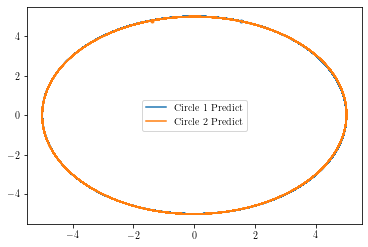

In [4]:
xpredict1_C1_MF,xpredict2_C1_MF,xpredict1_C2_MF,xpredict2_C2_MF,xy_1,Wout_alpha,M = trainRC_part1(rhospace,Minit,xcen,alpha,dt,
              t_time,ListenEndTime,TrainEndTime,PredictEndTime,Win,largest_evalue,N,dd1,omega1,dd2,omega2,gama,sigma,beta,
              FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol,rounding_no,sample_start,sample_end,stepback,Xcen1,ycen,
              iter_no,Xcen2)
plotpreds(xpredict1_C1_MF,xpredict2_C1_MF,xpredict1_C2_MF,xpredict2_C2_MF)

1.5433489638441227 4.77098048229715
-1.3965811599308935 4.801820275230807


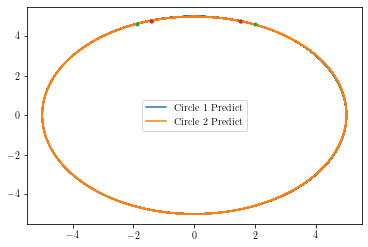

In [5]:
plotpreds(xpredict1_C1_MF[-5000:],xpredict2_C1_MF[-5000:],xpredict1_C2_MF[-5000:],xpredict2_C2_MF[-5000:])
plt.plot(xpredict1_C1_MF[-5000],xpredict2_C1_MF[-5000],'C2.')
plt.plot(xpredict1_C1_MF[-4990],xpredict2_C1_MF[-4990],'C3.')
plt.plot(xpredict1_C2_MF[-5000],xpredict2_C2_MF[-5000],'C2.')
plt.plot(xpredict1_C2_MF[-4990],xpredict2_C2_MF[-4990],'C3.')

### Inspect dynamics from random ICs

## FP1: (8.011575401192196,11.948578596471526)

first random IC (start): [ 0.98741278  0.76754611 -0.17951907  0.92026335  0.61014663 -0.43578053
  0.29412254 -0.72826872  0.0548313  -0.80412848]
(3.68207048797642,1.2682345157713881)


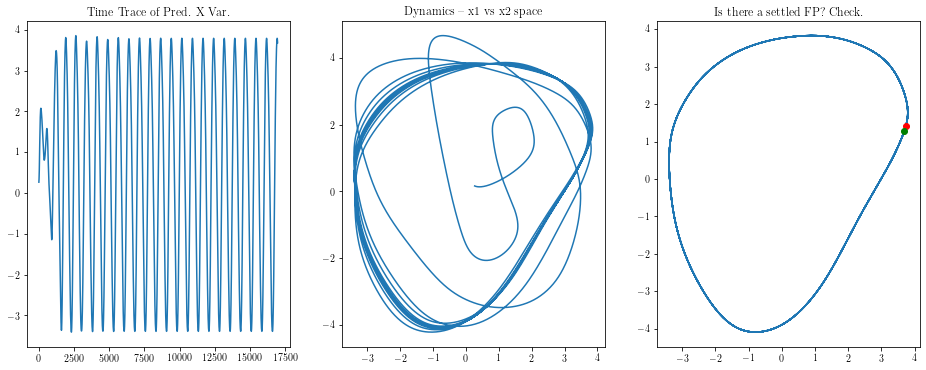

In [8]:
rand_vec1 = 2*np.random.random(N) - 1 #random initial condition size N = (426,)
#savedata('rand_vec1',rand_vec1)
#rand_vec1 = loaddata('rand_vec1')
print(f'first random IC (start): {rand_vec1[0:10]}')
inspect_from_random_IC(rand_vec1,xy_1,Wout_alpha,TrainEndTime,PredictEndTime,t_time,
                           dt,dd1,omega1,Xcen1,gama,sigma,M,Win)

first random IC (start): [ 0.2785517   0.71984217 -0.69321195  0.92141842  0.83023265 -0.26046323
  0.25383673  0.37976689 -0.04576431 -0.05810263]
(2.168166251256935,-4.511531917494811)


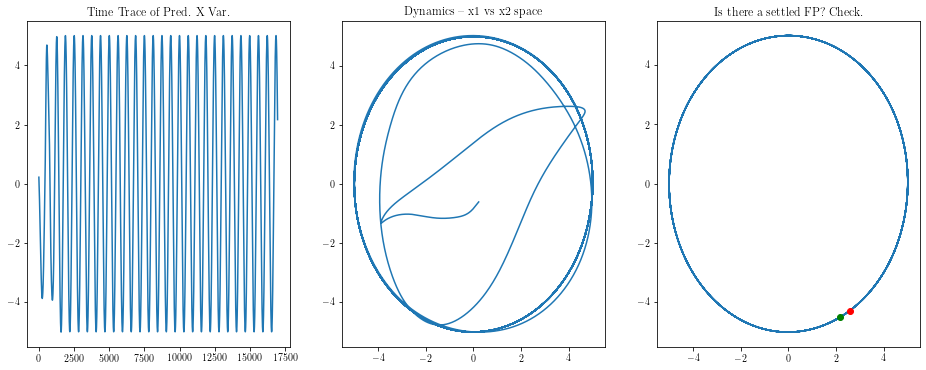

In [17]:
rand_vec1 = 2*np.random.random(N) - 1 #random initial condition size N = (426,)
#savedata('rand_vec1',rand_vec1)
#rand_vec1 = loaddata('rand_vec1')
print(f'first random IC (start): {rand_vec1[0:10]}')
inspect_from_random_IC(rand_vec1,xy_1,Wout_alpha,TrainEndTime,PredictEndTime,t_time,
                           dt,dd1,omega1,Xcen1,gama,sigma,M,Win)

first random IC (start): [ 0.2417097   0.73484865  0.75975945  0.93319644  0.45489402 -0.83532904
 -0.30055242  0.70782169 -0.33141457 -0.04186419]
(0.21886835522845197,-3.9869096438259612)


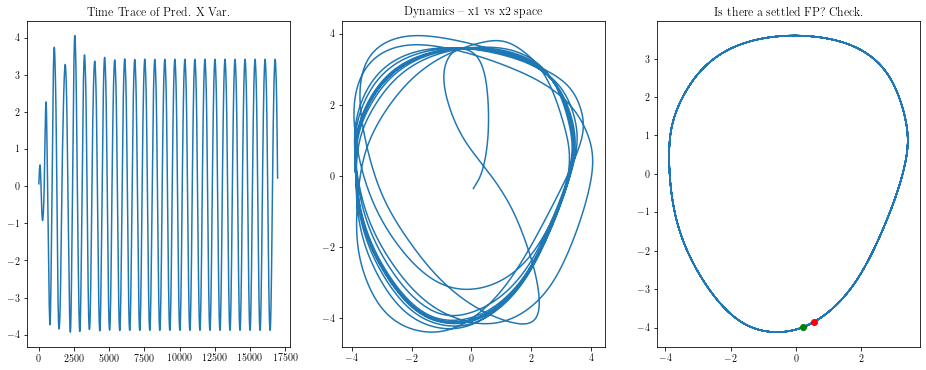

In [18]:
rand_vec1 = 2*np.random.random(N) - 1 #random initial condition size N = (426,)
#savedata('rand_vec1',rand_vec1)
#rand_vec1 = loaddata('rand_vec1')
print(f'first random IC (start): {rand_vec1[0:10]}')
inspect_from_random_IC(rand_vec1,xy_1,Wout_alpha,TrainEndTime,PredictEndTime,t_time,
                           dt,dd1,omega1,Xcen1,gama,sigma,M,Win)

first random IC (start): [ 0.10344775  0.67876239  0.07566025 -0.61524475 -0.21670118 -0.79931929
 -0.91838911  0.79631935 -0.8875938   0.43097261]
(3.106837172914465,3.939137620385926)


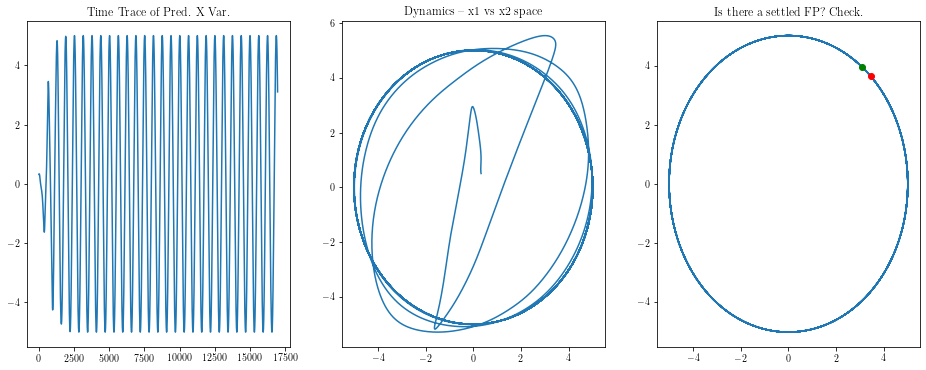

In [19]:
rand_vec1 = 2*np.random.random(N) - 1 #random initial condition size N = (426,)
#savedata('rand_vec1',rand_vec1)
#rand_vec1 = loaddata('rand_vec1')
print(f'first random IC (start): {rand_vec1[0:10]}')
inspect_from_random_IC(rand_vec1,xy_1,Wout_alpha,TrainEndTime,PredictEndTime,t_time,
                           dt,dd1,omega1,Xcen1,gama,sigma,M,Win)

first random IC (start): [ 0.07960947 -0.89926518 -0.82661614  0.76263127  0.05938791 -0.45871818
 -0.09014798 -0.42059277 -0.08850293  0.24118569]
(-0.5011295906581545,3.6685105153537774)


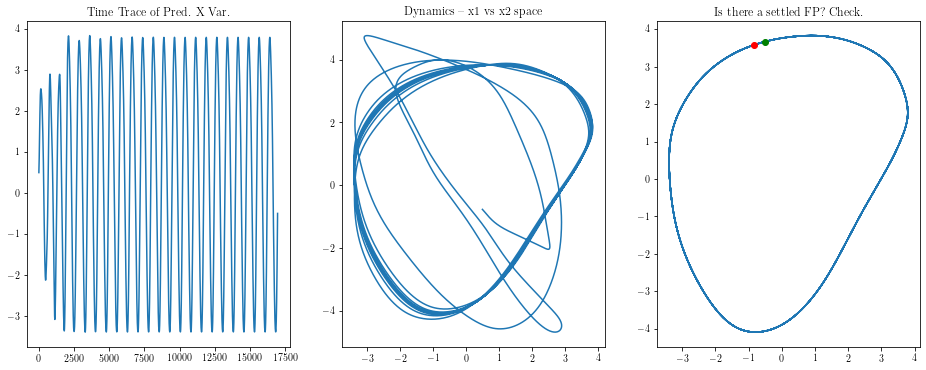

In [28]:
rand_vec1 = 2*np.random.random(N) - 1 #random initial condition size N = (426,)
#savedata('rand_vec1',rand_vec1)
#rand_vec1 = loaddata('rand_vec1')
print(f'first random IC (start): {rand_vec1[0:10]}')
inspect_from_random_IC(rand_vec1,xy_1,Wout_alpha,TrainEndTime,PredictEndTime,t_time,
                           dt,dd1,omega1,Xcen1,gama,sigma,M,Win)

## FP2: (9.62898186175914,-9.986863823744724)

third random IC (start): [ 0.80980211  0.32212358  0.53866487 -0.87656175 -0.69905408  0.33582725
 -0.13924971 -0.99303021  0.63344985 -0.30194417]
(1.3688131854051442,4.2353109270055525)


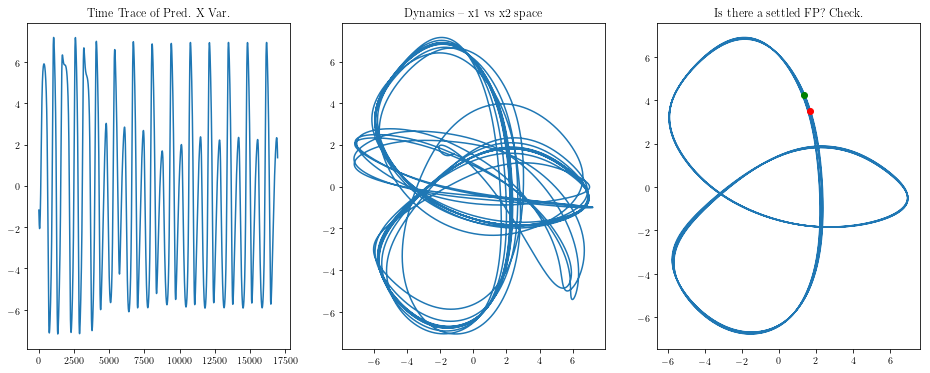

In [229]:
rand_vec3 = loaddata('rand_vec3')
print(f'third random IC (start): {rand_vec3[0:10]}')
inspect_from_random_IC(rand_vec3,xy_1,Wout_alpha,TrainEndTime,PredictEndTime,t_time,
                           dt,dd1,omega1,Xcen1,gama,sigma,M,Win)

### How does FP1 evolve wrt $\rho$? BROADLY...

In [7]:
# rho_max=2.5
# rho_min=0.2
# rho_steps=1500
# rhospace=np.linspace(rho_min,rho_max,rho_steps)
# R1_0=np.empty([rho_steps,N]) #random starting pts
# FP1_0=np.empty([rho_steps,6]) #fp1 evolution
# ErrCs1_0 = np.empty([rho_steps,1]) #err codes
# trajsave = np.empty([rho_steps,4])

In [8]:
# xpr1_0, xpr2_0,R1_0,FP1_0,ErrCs1_0,trajsave = limitcycletracking(-rand_vec1,R1_0,FP1_0,
#                        trajsave,ErrCs1_0,
#                        xy_1,Minit,xcen,dt,t_time,ListenEndTime,TrainEndTime,
#                        Win,N,dd1,omega1,dd2,omega2,gama,sigma,alpha,beta,
#                        PredictEndTime,Xcen1,sample_start,sample_end,stepback,
#                        FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol)

In [9]:
#savedata('FP1_0',FP1_0)
#savedata('ErrCs1_0',ErrCs1_0)
FP1_0 = loaddata('FP1_0_1500')
ErrCs1_0 = loaddata('ErrCs1_0_1500')
print(FP1_0.shape)
print(ErrCs1_0.shape)

display_results(FP1_0, ErrCs1_0)

(1500, 6)
(1500, 1)


0      1                    2    3                   4  \
0                FP  444.0                  0.2  0.0   37.62842722692044   
1                FP  444.0  0.20153435623749166  0.0   37.45944515604853   
2                FP  444.0  0.20306871247498334  0.0  37.237696299762135   
3                FP  444.0    0.204603068712475  0.0   37.01767247497202   
4                FP  444.0  0.20613742494996665  0.0   36.79935998883477   
5                FP  444.0  0.20767178118745833  0.0   36.58274443531959   
6                FP  444.0  0.20920613742494998  0.0  36.367810839309726   
7                FP  444.0  0.21074049366244163  0.0  36.154543736887454   
8                FP  444.0   0.2122748498999333  0.0  35.942927257248556   
9                FP  444.0  0.21380920613742496  0.0   35.73294530190106   
10               FP  444.0  0.21534356237491661  0.0   35.52458153924261   
11               FP  444.0   0.2168779186124083  0.0   35.31781954050581   
12               FP  444.0  0.21841227484989995  0.0   35.11264289846917   
13               FP  444.0   0.2199466310873916  0.0   34.90903519399601   
14               FP  444.0  0.22148098732488328  0.0     34.706980168272   
15               FP  444.0  0.22301534356237493  0.0  34.506461716032504   
16               FP  444.0  0.22454969979986658  0.0   34.30746403915415   
17               FP  444.0  0.22608405603735826  0.0   34.10997160573927   
18               FP  444.0   0.2276184122748499  0.0   33.91396921993007   
19               FP  444.0  0.22915276851234156  0.0   33.71944214314776   
20               FP  444.0  0.23068712474983322  0.0   33.52637606127915   
21               FP  444.0   0.2322214809873249  0.0   33.33475712374663   
22               FP  444.0  0.23375583722481655  0.0  33.144571993144424   
23               FP  444.0  0.23529019346230823  0.0   32.95580795662911   
24               FP  444.0  0.23682454969979988  0.0  32.768452742368574   
25               FP  444.0  0.23835890593729153  0.0   32.58249478894798   
26               FP  444.0  0.23989326217478318  0.0    32.3979229904263   
27               FP  444.0  0.24142761841227486  0.0    32.2147271444754   
28               FP  444.0  0.24296197464976652  0.0   32.03289737106597   
29               FP  444.0   0.2444963308872582  0.0  31.852424531215384   
30               FP  444.0  0.24603068712474985  0.0  31.673300194244405   
31               FP  444.0   0.2475650433622415  0.0  31.495516508825535   
32               FP  444.0  0.24909939959973315  0.0  31.319066212047137   
33               FP  444.0   0.2506337558372248  0.0  31.143942711566716   
34               FP  444.0   0.2521681120747165  0.0  30.970140064578576   
35               FP  444.0  0.25370246831220816  0.0   30.79765284439906   
36               FP  444.0   0.2552368245496998  0.0   30.62647623210694   
37               FP  444.0  0.25677118078719147  0.0   30.45660600373283   
38               FP  444.0   0.2583055370246831  0.0  30.288038447106363   
39               FP  444.0  0.25983989326217477  0.0   30.12077036947913   
40               FP  444.0   0.2613742494996665  0.0  29.954799082797756   
41               FP  444.0  0.26290860573715813  0.0   29.79012235624304   
42               FP  444.0   0.2644429619746498  0.0  29.626738375768443   
43               FP  444.0  0.26597731821214143  0.0  29.464645752964344   
44               FP  444.0   0.2675116744496331  0.0   29.30384351891708   
45               FP  444.0  0.26904603068712474  0.0  29.144330956011835   
46               FP  444.0   0.2705803869246164  0.0  28.986107725202555   
47               FP  444.0   0.2721147431621081  0.0   28.82917374654309   
48               FP  444.0  0.27364909939959975  0.0   28.67352914844588   
49               FP  444.0   0.2751834556370914  0.0  28.519174328657627   
50               FP  444.0  0.27671781187458305  0.0   28.36610979592294   
51               FP  444.0   0.2782521681120747  0.0  28.214336218

### Go backwards...

In [10]:
# rho_max=0.2
# rho_min=2.5
# rho_steps=1500
# rhospace=np.linspace(rho_min,rho_max,rho_steps)
# R1_0rev=np.empty([rho_steps,N]) #random starting pts
# FP1_0rev=np.empty([rho_steps,6]) #fp1 evolution
# ErrCs1_0rev = np.empty([rho_steps,1]) #err codes

In [11]:
# xpr1_0, xpr2_0,R1_0rev,FP1_0rev,ErrCs1_0rev = limitcycletracking(-rand_vec1,R1_0rev,FP1_0rev,
#                        ErrCs1_0rev,                                          
#                        xy_1,Minit,xcen,dt,t_time,ListenEndTime,TrainEndTime,
#                        Win,N,dd1,omega1,dd2,omega2,gama,sigma,alpha,beta,
#                        PredictEndTime,Xcen1,sample_start,sample_end,stepback,
#                        FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol)

In [12]:
#savedata('FP1_0rev_1500',FP1_0rev)
#savedata('ErrCs1_0rev_1500',ErrCs1_0rev)
FP1_0rev = loaddata('FP1_0rev_1500')
ErrCs1_0rev = loaddata('ErrCs1_0rev_1500')
#print(FP1_0rev)
#print(ErrCs1_0rev)

display_results(FP1_0rev,ErrCs1_0rev)

0      1                    2    3                    4  \
0     Switch_chaos1    9.0                  2.5  0.0    4.585263511883934   
1     Switch_chaos1    9.0    2.498465643762508  0.0    4.540362463872649   
2     Switch_chaos1    9.0   2.4969312875250167  0.0    4.595412712888829   
3     Switch_chaos1    9.0    2.495396931287525  0.0    4.715472764738484   
4          CA_clean    2.0   2.4938625750500334  0.0   4.1469603288432095   
5          CA_clean    2.0   2.4923282188125415  0.0      4.0854869861568   
6          CA_clean    2.0     2.49079386257505  0.0    4.091043513629814   
7          CA_clean    2.0    2.489259506337558  0.0    4.075763410953849   
8          CA_clean    2.0    2.487725150100067  0.0    4.120109489029872   
9          CA_clean    2.0    2.486190793862575  0.0    4.187109432225217   
10           Switch    6.0   2.4846564376250835  0.0    4.213980809109764   
11           Switch    6.0   2.4831220813875916  0.0     4.33494325523036   
12         CB_clean    5.0      2.4815877251501  0.0     4.88075336586501   
13         CB_clean    5.0   2.4800533689126083  0.0    4.297331629026525   
14         CB_clean    5.0    2.478519012675117  0.0    4.302756639280211   
15         CB_clean    5.0    2.476984656437625  0.0    4.381234097660367   
16         CB_clean    5.0   2.4754503002001336  0.0   4.5460225275039745   
17         CB_clean    5.0   2.4739159439626417  0.0   4.4275830224303725   
18         CB_clean    5.0   2.4723815877251503  0.0    4.499391590780253   
19         CB_clean    5.0   2.4708472314876584  0.0    4.689087466538502   
20         CB_clean    5.0    2.469312875250167  0.0    4.704813750434529   
21         CB_clean    5.0    2.467778519012675  0.0    4.686763039647759   
22         CB_clean    5.0   2.4662441627751837  0.0    4.584343049865076   
23         CB_clean    5.0    2.464709806537692  0.0    4.429995667513621   
24         CB_clean    5.0   2.4631754503002004  0.0    4.502825714357822   
25         CB_clean    5.0   2.4616410940627085  0.0    4.697703387652754   
26         CB_clean    5.0   2.4601067378252166  0.0    4.689161810165657   
27         CB_clean    5.0    2.458572381587725  0.0    4.684641782014882   
28         CB_clean    5.0   2.4570380253502333  0.0    4.591543954677884   
29       CA_chaotic    7.0    2.455503669112742  0.0    5.356108289252674   
30         CA_clean    2.0     2.45396931287525  0.0    5.358051048008051   
31         CA_clean    2.0   2.4524349566377586  0.0   4.9799401269389705   
32         CB_clean    5.0   2.4509006004002667  0.0   5.0902240562218575   
33         CB_clean    5.0   2.4493662441627753  0.0   4.4189203910967585   
34    Switch_chaos1    9.0   2.4478318879252834  0.0     5.28178171964361   
35         CB_clean    5.0    2.446297531687792  0.0    4.460471401988697   
36         CB_clean    5.0      2.4447631754503  0.0    5.104046296724787   
37         CB_clean    5.0   2.4432288192128087  0.0    4.981461035155567   
38         CB_clean    5.0    2.441694462975317  0.0   4.8574520749210555   
39         CB_clean    5.0   2.4401601067378254  0.0    5.631293944246831   
40         CB_clean    5.0   2.4386257505003335  0.0    4.515186146079254   
41       CA_chaotic    8.0    2.437091394262842  0.0    5.198196802147945   
42    Switch_chaos1    9.0     2.43555703802535  0.0    5.943403965168396   
43    Switch_chaos1    9.0   2.4340226817878587  0.0    5.659962943124157   
44    Switch_chaos1    9.0    2.432488325550367  0.0    5.326866411313429   
45    Switch_chaos1    9.0   2.4309539693128754  0.0    5.192718336923536   
46    Switch_chaos1    9.0   2.4294196130753836  0.0    4.992198499970306   
47    Switch_chaos1    9.0    2.427885256837892  0.0    5.181049493422966   
48    Switch_chaos1    9.0   2.4263509006004003  0.0    5.250760236604859   
49    Switch_chaos1    9.0   2.4248165443629084  0.0     4.98771442374066   
50         CA_clean    2.0    2.423282188125417  0.0    5.384546701759854   
51       CA_ch

### How does FP2 evolve wrt $\rho$? BROADLY...

In [13]:
# rho_max=2.5
# rho_min=0.2
# rho_steps=1500
# rhospace=np.linspace(rho_min,rho_max,rho_steps)
# R2_0=np.empty([rho_steps,N]) #random starting pts
# FP2_0=np.empty([rho_steps,6]) #fp evolution
# ErrCs2_0 = np.empty([rho_steps,1]) #err codes

In [14]:
# xpr1_0, xpr2_0,R2_0,FP2_0,ErrCs2_0 = limitcycletracking(-rand_vec3,R2_0,FP2_0,
#                        ErrCs2_0,
#                        xy_1,Minit,xcen,dt,t_time,ListenEndTime,TrainEndTime,
#                        Win,N,dd1,omega1,dd2,omega2,gama,sigma,alpha,beta,
#                        PredictEndTime,Xcen1,sample_start,sample_end,stepback,
#                        FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol)

In [15]:
#savedata('FP2_0',FP2_0)
#savedata('ErrCs2_0',ErrCs2_0)
FP2_0 = loaddata('FP2_0_1500')
ErrCs2_0 = loaddata('ErrCs2_0_1500')
#print(FP2_0)
#print(ErrCs2_0)

display_results(FP2_0,ErrCs2_0)

0      1                    2    3                   4  \
0                FP  444.0                  0.2  0.0  31.195801884915305   
1                FP  444.0  0.20153435623749166  0.0  31.066609414669095   
2                FP  444.0  0.20306871247498334  0.0  30.850526237888094   
3                FP  444.0    0.204603068712475  0.0   30.63567314082629   
4                FP  444.0  0.20613742494996665  0.0  30.422050013605023   
5                FP  444.0  0.20767178118745833  0.0   30.20965580311327   
6                FP  444.0  0.20920613742494998  0.0  29.998488691439743   
7                FP  444.0  0.21074049366244163  0.0   29.78854617689431   
8                FP  444.0   0.2122748498999333  0.0  29.579825184246385   
9                FP  444.0  0.21380920613742496  0.0   29.37232210709584   
10               FP  444.0  0.21534356237491661  0.0  29.166032977874533   
11               FP  444.0   0.2168779186124083  0.0    28.9609534721889   
12               FP  444.0  0.21841227484989995  0.0  28.757079022990293   
13               FP  444.0   0.2199466310873916  0.0  28.554404966135046   
14               FP  444.0  0.22148098732488328  0.0  28.352926450839174   
15               FP  444.0  0.22301534356237493  0.0  28.152638660658553   
16               FP  444.0  0.22454969979986658  0.0  27.953536815034525   
17               FP  444.0  0.22608405603735826  0.0   27.75561622248666   
18               FP  444.0   0.2276184122748499  0.0   27.55887235366308   
19               FP  444.0  0.22915276851234156  0.0  27.363300918537465   
20               FP  444.0  0.23068712474983322  0.0  27.168897895630142   
21               FP  444.0   0.2322214809873249  0.0    26.9756595427211   
22               FP  444.0  0.23375583722481655  0.0   26.78358249619596   
23               FP  444.0  0.23529019346230823  0.0  26.592663775260046   
24               FP  444.0  0.23682454969979988  0.0   26.40290081006761   
25               FP  444.0  0.23835890593729153  0.0   26.21429154498016   
26               FP  444.0  0.23989326217478318  0.0  26.026834369606615   
27               FP  444.0  0.24142761841227486  0.0  25.840528381124642   
28               FP  444.0  0.24296197464976652  0.0  25.655372937113707   
29               FP  444.0   0.2444963308872582  0.0  25.471368033055636   
30               FP  444.0  0.24603068712474985  0.0   25.28851436871242   
31               FP  444.0   0.2475650433622415  0.0  25.106813154541662   
32               FP  444.0  0.24909939959973315  0.0   24.92626618347986   
33               FP  444.0   0.2506337558372248  0.0  24.746875925637667   
34               FP  444.0   0.2521681120747165  0.0  24.568645467601165   
35               FP  444.0  0.25370246831220816  0.0  24.391578455474644   
36               FP  444.0   0.2552368245496998  0.0  24.215679195096566   
37               FP  444.0  0.25677118078719147  0.0   24.04095262879422   
38               FP  444.0   0.2583055370246831  0.0  23.867404234910552   
39               FP  444.0  0.25983989326217477  0.0  23.695040173453368   
40               FP  444.0   0.2613742494996665  0.0  23.523867160284947   
41               FP  444.0  0.26290860573715813  0.0   23.35389250026358   
42               FP  444.0   0.2644429619746498  0.0  23.185124050128092   
43               FP  444.0  0.26597731821214143  0.0  23.017570241358804   
44               FP  444.0   0.2675116744496331  0.0    22.8512399926048   
45               FP  444.0  0.26904603068712474  0.0  22.686142743638406   
46               FP  444.0   0.2705803869246164  0.0  22.522288436469037   
47               FP  444.0   0.2721147431621081  0.0    22.3596874493973   
48               FP  444.0  0.27364909939959975  0.0  22.198350610143592   
49               FP  444.0   0.2751834556370914  0.0  22.038289149409234   
50               FP  444.0  0.27671781187458305  0.0   21.87951463838208   
51               FP  444.0   0.2782521681120747  0.0  21.722039035

### Go backwards...

In [16]:
# rho_max=0.2
# rho_min=2.5
# rho_steps=1500
# rhospace=np.linspace(rho_min,rho_max,rho_steps)
# R2_0rev=np.empty([rho_steps,N]) #random starting pts
# FP2_0rev=np.empty([rho_steps,6]) #fp evolution
# ErrCs2_0rev = np.empty([rho_steps,1]) #err codes

In [17]:
# xpr1_0, xpr2_0,R2_0rev,FP2_0rev,ErrCs2_0rev = limitcycletracking(-rand_vec3,R2_0rev,FP2_0rev,
#                        ErrCs2_0rev,
#                        xy_1,Minit,xcen,dt,t_time,ListenEndTime,TrainEndTime,
#                        Win,N,dd1,omega1,dd2,omega2,gama,sigma,alpha,beta,
#                        PredictEndTime,Xcen1,sample_start,sample_end,stepback,
#                        FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol)

In [18]:
#savedata('FP2_0rev',FP2_0rev)
#savedata('ErrCs2_0rev',ErrCs2_0rev)
FP2_0rev = loaddata('FP2_0rev_1500')
ErrCs2_0rev = loaddata('ErrCs2_0rev_1500')
# print(FP2_0rev)
# print(ErrCs2_0rev)

display_results(FP2_0rev,ErrCs2_0rev)

0      1                    2    3                   4  \
0          CB_clean    5.0                  2.5  0.0   4.853967621814601   
1          CB_clean    5.0    2.498465643762508  0.0   4.783236995651512   
2          CB_clean    5.0   2.4969312875250167  0.0  4.9355675752096015   
3          CB_clean    5.0    2.495396931287525  0.0   4.985553258400896   
4          CB_clean    5.0   2.4938625750500334  0.0   5.138180688485086   
5          CB_clean    5.0   2.4923282188125415  0.0  5.0191733226099835   
6          CB_clean    5.0     2.49079386257505  0.0  5.0034207738363525   
7          CB_clean    5.0    2.489259506337558  0.0   4.999018632389528   
8          CB_clean    5.0    2.487725150100067  0.0   4.994388826327149   
9          CB_clean    5.0    2.486190793862575  0.0   4.971072303507134   
10         CB_clean    5.0   2.4846564376250835  0.0   4.922270195221727   
11         CB_clean    5.0   2.4831220813875916  0.0   4.949282830073012   
12         CB_clean    5.0      2.4815877251501  0.0  5.1021351849131396   
13         CB_clean    5.0   2.4800533689126083  0.0   5.086263515347122   
14         CB_clean    5.0    2.478519012675117  0.0   5.127462963158594   
15         CB_clean    5.0    2.476984656437625  0.0   5.054081868825188   
16         CB_clean    5.0   2.4754503002001336  0.0   4.935186528200364   
17         CB_clean    5.0   2.4739159439626417  0.0   4.891317999148718   
18         CB_clean    5.0   2.4723815877251503  0.0   4.856308003616982   
19         CB_clean    5.0   2.4708472314876584  0.0   4.811395934509171   
20       CA_chaotic    8.0    2.469312875250167  0.0   4.663719186517034   
21         CB_clean    5.0    2.467778519012675  0.0   4.595301188240786   
22         CB_clean    5.0   2.4662441627751837  0.0   4.994895209646512   
23         CB_clean    5.0    2.464709806537692  0.0  5.1014036456663545   
24         CB_clean    5.0   2.4631754503002004  0.0   4.879802523232831   
25         CB_clean    5.0   2.4616410940627085  0.0   4.657973751585238   
26         CB_clean    5.0   2.4601067378252166  0.0   4.602042753666081   
27         CB_clean    5.0    2.458572381587725  0.0   5.007700453089363   
28         CB_clean    5.0   2.4570380253502333  0.0   5.037050976238546   
29       CA_chaotic    8.0    2.455503669112742  0.0   5.352630309945387   
30       CA_chaotic    8.0     2.45396931287525  0.0   4.971135236037491   
31         CB_clean    5.0   2.4524349566377586  0.0  4.5978055049321265   
32         CB_clean    5.0   2.4509006004002667  0.0   4.757549215942396   
33         CB_clean    5.0   2.4493662441627753  0.0   4.682703932278877   
34         CB_clean    5.0   2.4478318879252834  0.0   4.759914902620086   
35         CB_clean    5.0    2.446297531687792  0.0   4.769811711419101   
36       CA_chaotic    8.0      2.4447631754503  0.0   4.910615579140315   
37       CA_chaotic    8.0   2.4432288192128087  0.0   4.902231538886601   
38         CB_clean    5.0    2.441694462975317  0.0   4.999369690816979   
39    Switch_chaos1    9.0   2.4401601067378254  0.0  5.4556291016588565   
40       CA_chaotic    8.0   2.4386257505003335  0.0   5.174206097205542   
41         CB_clean    5.0    2.437091394262842  0.0   5.130675779840175   
42         CB_clean    5.0     2.43555703802535  0.0   4.819415833099409   
43         CB_clean    5.0   2.4340226817878587  0.0   4.632705358335179   
44         CB_clean    5.0    2.432488325550367  0.0  4.9494845082642165   
45         CB_clean    5.0   2.4309539693128754  0.0   4.585711092756743   
46         CB_clean    5.0   2.4294196130753836  0.0   4.809444863985588   
47         CB_clean    5.0    2.427885256837892  0.0   4.818836563044302   
48         CB_clean    5.0   2.4263509006004003  0.0  4.7160872757715095   
49         CB_clean    5.0   2.4248165443629084  0.0   4.488754890123025   
50         CA_clean    2.0    2.423282188125417  0.0   5.599371175993457   
51         CA_clean    2.0    2.421747831887925  0.0    4.98933456

### Now, in detail, get FP, LC and C's for FP1.

### FP for FP1

In [153]:
rho_max=0.71
rho_min=0.7
rho_steps=101
rhospace=np.round(np.linspace(rho_min,rho_max,rho_steps),6)
R1_12_1=np.empty([rho_steps,N]) 
FP1_12_1=np.empty([rho_steps,4])
rand_vec1 = R1_111[200]#loaddata('rand_vec1')
# start from random vec leading to (8.011575394768629,11.948578613390712)
xpr1_12_1, xpr2_12_1, rho_12_1, FP1_12_1, R1_12_1 = inspect_from_random_IC_for_multiple_rho_KEEP_GOING(
                                     -rand_vec1,rhospace,Minit,xcen,dt,t_time,
                                     ListenEndTime,TrainEndTime,Win,N,dd1,omega1,
                                     dd2,omega2,gama,sigma,alpha,beta,xy_1,
                                     PredictEndTime,Xcen1,FP_err_lim,
                                     R1_12_1,FP1_12_1)

rho=0.7, Xcen=0.0, FP: (-2.93560266233216,-8.886021064785103)
rho=0.7001, Xcen=0.0, FP: (-2.917355429878987,-8.858569731399436)
rho=0.7002, Xcen=0.0, FP: (-2.8984903742800987,-8.82989271732535)
rho=0.7003, Xcen=0.0, FP: (-2.8788386348982824,-8.799701215275489)
rho=0.7004, Xcen=0.0, FP: (-2.8581641460096923,-8.767589429390714)
rho=0.7005, Xcen=0.0, FP: (-2.8361132328402983,-8.732948077138577)
rho=0.7006, Xcen=0.0, FP: (-2.812114141816471,-8.694790199977747)
rho=0.7007, Xcen=0.0, FP: (-2.7851197477101595,-8.6513072485925)
rho=0.7008, Xcen=0.0, FP: (-2.752759959760213,-8.598406207801837)
rho=0.7009, Xcen=0.0, FP: (-2.7066098154762113,-8.521532165782281)
Bifurcation possible: 0.701,0.0,4.0
rho=0.701, Xcen=0.0, FP: (-0.4518162459303381,7.328020868183502)
Bifurcation possible: 0.7011,0.0,4.0
rho=0.7011, Xcen=0.0, FP: (2.4895545589115993,8.141527290714897)


KeyboardInterrupt: 

In [32]:
rho_max=0.814
rho_min=0.784
rho_steps=301
rhospace=np.round(np.linspace(rho_min,rho_max,rho_steps),6)
R1_0r1=np.empty([rho_steps,N]) #random starting pts
LC1_0r1=np.empty([rho_steps,6]) #fp1 evolution
ErrCs1_0r1 = np.empty([rho_steps,1]) #err codes
trajtime=int(7000)
trajsavex_r1 = np.empty([rho_steps,trajtime])
trajsavey_r1 = np.empty([rho_steps,trajtime])
rhospace

array([0.784 , 0.7841, 0.7842, 0.7843, 0.7844, 0.7845, 0.7846, 0.7847,
       0.7848, 0.7849, 0.785 , 0.7851, 0.7852, 0.7853, 0.7854, 0.7855,
       0.7856, 0.7857, 0.7858, 0.7859, 0.786 , 0.7861, 0.7862, 0.7863,
       0.7864, 0.7865, 0.7866, 0.7867, 0.7868, 0.7869, 0.787 , 0.7871,
       0.7872, 0.7873, 0.7874, 0.7875, 0.7876, 0.7877, 0.7878, 0.7879,
       0.788 , 0.7881, 0.7882, 0.7883, 0.7884, 0.7885, 0.7886, 0.7887,
       0.7888, 0.7889, 0.789 , 0.7891, 0.7892, 0.7893, 0.7894, 0.7895,
       0.7896, 0.7897, 0.7898, 0.7899, 0.79  , 0.7901, 0.7902, 0.7903,
       0.7904, 0.7905, 0.7906, 0.7907, 0.7908, 0.7909, 0.791 , 0.7911,
       0.7912, 0.7913, 0.7914, 0.7915, 0.7916, 0.7917, 0.7918, 0.7919,
       0.792 , 0.7921, 0.7922, 0.7923, 0.7924, 0.7925, 0.7926, 0.7927,
       0.7928, 0.7929, 0.793 , 0.7931, 0.7932, 0.7933, 0.7934, 0.7935,
       0.7936, 0.7937, 0.7938, 0.7939, 0.794 , 0.7941, 0.7942, 0.7943,
       0.7944, 0.7945, 0.7946, 0.7947, 0.7948, 0.7949, 0.795 , 0.7951,
      

In [33]:
#RCb_IC_rho400=R1_0r1[-1]

In [34]:
#rand_vec1=2*np.random.random(N) - 1
#R1_0r[-1]
#RCb_IC_rho135=R1_0r1[65]
#RCb_IC_rho250=R1_0r1[-1]
xpr1_0r1, xpr2_0r1,R1_0r1,LC1_0r1,ErrCs1_0r1,trajsavex_r1,trajsavey_r1 = limitcycletracking(-rand_vec1,R1_0r1,LC1_0r1,
                       trajsavex_r1,trajsavey_r1,trajtime,ErrCs1_0r1,
                       xy_1,Minit,xcen,dt,t_time,ListenEndTime,TrainEndTime,
                       Win,N,dd1,omega1,dd2,omega2,gama,sigma,alpha,beta,
                       PredictEndTime,Xcen1,sample_start,sample_end,stepback,
                       FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol)

some LC -- [0.784, 0.0, 2.0, 1.2134142621935715, 6.97401787308293, -0.5538343534004263]
some LC -- [0.7841, 0.0, 2.0, 1.2014811097046523, 6.87486019820459, -0.32486700306212396]
some LC -- [0.7842, 0.0, 2.0, 1.1991821222797978, 6.872910407227365, -0.3353953481407423]
some LC -- [0.7843, 0.0, 2.0, 1.2063951135403912, 6.87242146315415, -0.3349093626864866]
some LC -- [0.7844, 0.0, 2.0, 1.194709813761993, 6.868336337061467, -0.328712964478673]
some LC -- [0.7845, 0.0, 2.0, 1.2019136882958565, 6.865682789589436, -0.32094093670738977]
some LC -- [0.7846, 0.0, 2.0, 1.199573611214402, 6.865157269903629, -0.3000138300917981]
some LC -- [0.7847, 0.0, 2.0, 1.1946834383423561, 6.860795323586921, -0.3103086017442445]
some LC -- [0.7848, 0.0, 2.0, 1.195210807443027, 6.860096179251252, -0.3030384956764785]
some LC -- [0.7849, 0.0, 2.0, 1.1383475388315047, 6.857183749806458, -0.28673560518080665]
some LC -- [0.785, 0.0, 2.0, 1.1819168350751041, 6.854771823891734, -0.2896905538771375]
some LC -- [0.78

some LC -- [0.7931, 0.0, 2.0, 1.0553776702580162, 6.747868573252674, -0.046147384532329035]
some LC -- [0.7932, 0.0, 2.0, 1.053779101346903, 6.746862386648495, -0.046712260647000035]
some LC -- [0.7933, 0.0, 2.0, 1.0529238670422447, 6.746063520568717, -0.04258851658912435]
some LC -- [0.7934, 0.0, 2.0, 1.0516095151273737, 6.744975474196734, -0.034727902473455176]
some LC -- [0.7935, 0.0, 2.0, 1.0502963437623944, 6.743627565748516, -0.04983690053822774]
some LC -- [0.7936, 0.0, 2.0, 1.0489672695048338, 6.742567352251404, -0.03574354412400097]
some LC -- [0.7937, 0.0, 2.0, 1.0435886948526527, 6.74145530183987, -0.021043416797532775]
some LC -- [0.7938, 0.0, 2.0, 1.0463318752554742, 6.740424998960207, -0.03272106266321757]
some LC -- [0.7939, 0.0, 2.0, 1.0449838501474948, 6.73930382468489, -0.014938411547825402]
some LC -- [0.794, 0.0, 2.0, 1.0436414663552287, 6.738217007161617, -0.02341097430841186]
some LC -- [0.7941, 0.0, 2.0, 1.0423222621920076, 6.736911120291734, -0.03089847170819074

Circle A, kind of chaotic -- [0.8022, 0.0, 7.0, 0.24886806321983657, 5.613575580933145, 0.29028060972692976]
Circle A, kind of chaotic -- [0.8023, 0.0, 7.0, 0.20974941479015224, 5.604521007865385, 0.227222731709854]
Circle A, kind of chaotic -- [0.8024, 0.0, 7.0, 0.22774340196555629, 5.596450848456082, 0.11287429107973067]
Circle A, kind of chaotic -- [0.8025, 0.0, 7.0, 0.2190014586986057, 5.594919607554531, 0.2948874122681545]
Circle A, kind of chaotic -- [0.8026, 0.0, 7.0, 0.21446053398913995, 5.586026422761004, 0.2663867375027737]
Circle A, kind of chaotic -- [0.8027, 0.0, 7.0, 0.21771430474838308, 5.58663314258382, 0.17156613971442705]
Circle A, kind of chaotic -- [0.8028, 0.0, 7.0, 0.1930257207693285, 5.579886467603215, 0.23399539572225145]
Circle A, kind of chaotic -- [0.8029, 0.0, 7.0, 0.2012301255849927, 5.569928020872204, 0.14580489201931698]
Circle A, kind of chaotic -- [0.803, 0.0, 7.0, 0.20565646534591067, 5.564509269723875, 0.137329981100417]
Circle A, kind of chaotic -- [

Circle A (clean) -- [0.8099, 0.0, 2.0, 0.041214479322895556, 5.174607407212257, -0.18331974306007134]
Circle A (clean) -- [0.81, 0.0, 2.0, 0.04126047184314345, 5.1748242704226595, -0.17593509955793]
Circle A (clean) -- [0.8101, 0.0, 2.0, 0.04127109058573673, 5.174982828636119, -0.2037196609243955]
Circle A (clean) -- [0.8102, 0.0, 2.0, 0.04128766525051351, 5.174805258329069, -0.1712767450592386]
Circle A (clean) -- [0.8103, 0.0, 2.0, 0.04129127868426614, 5.175096520456801, -0.18606767930170448]
Circle A (clean) -- [0.8104, 0.0, 2.0, 0.041249321035197066, 5.174808349587599, -0.1835123012347382]
Circle A (clean) -- [0.8105, 0.0, 2.0, 0.04117621150656395, 5.174188076802871, -0.1707480985436489]
Circle A (clean) -- [0.8106, 0.0, 2.0, 0.041131438453096525, 5.174049537602977, -0.18855073238765313]
Circle A (clean) -- [0.8107, 0.0, 2.0, 0.041136557206708405, 5.174002644302233, -0.15988936640844062]
Circle A (clean) -- [0.8108, 0.0, 2.0, 0.041182303561904644, 5.174320793640777, -0.159681312412

In [35]:
#savedata('mLCp2trackx_rho_0784_0884_moredata',trajsavex_r1)
#savedata('mLCp2tracky_rho_0784_0884_moredata',trajsavey_r1)

In [11]:
#Ca: rho=[0.8078,2.0810]
Ca_x_rho_079_073=loaddata('CAtrackx_rho_079_073')[::-1]#
Ca_y_rho_079_073=loaddata('CAtracky_rho_079_073')[::-1]#
Ca_x_rho_079_075=loaddata('CAtrackx_rho_079_075')#
Ca_y_rho_079_075=loaddata('CAtracky_rho_079_075')#
Ca_x_rho_080_079=loaddata('CAtrackx_rho_080_079')[::-1]#
Ca_y_rho_080_079=loaddata('CAtracky_rho_080_079')[::-1]#
Ca_x_rho_080_083=loaddata('CAtrackx_rho_080_083')#
Ca_y_rho_080_083=loaddata('CAtracky_rho_080_083')#
Ca_x_rho_083_253=loaddata('CAtrackx_rho_083_253')#
Ca_y_rho_083_253=loaddata('CAtracky_rho_083_253')#
Ca_x_rho_080_250=loaddata('Catrackx_rho_080_250')#
Ca_y_rho_080_250=loaddata('Catracky_rho_080_250')#

#Cb: rho=[1.2956,2.2210]
Cb_x_rho_135_125=loaddata('Cbtrackx_rho_135_125')[::-1]#
Cb_y_rho_135_125=loaddata('Cbtracky_rho_135_125')[::-1]#
Cb_x_rho_130_126=loaddata('Cbtrackx_rho_130_126')[::-1]#
Cb_y_rho_130_126=loaddata('Cbtracky_rho_130_126')[::-1]#
Cb_x_rho_130_250=loaddata('Cbtrackx_rho_130_250')#
Cb_y_rho_130_250=loaddata('Cbtracky_rho_130_250')#
Cb_x_rho_200_050=loaddata('Cbtrackx_rho_200_050')#
Cb_y_rho_200_050=loaddata('Cbtracky_rho_200_050')#

trajsavex_r4=loaddata('Cbtrackx_rho_250_300')#
trajsavey_r4=loaddata('Cbtracky_rho_250_300')#
trajsavex_r5=loaddata('Cbtrackx_rho_300_301')#
trajsavey_r5=loaddata('Cbtracky_rho_300_301')#
trajsavex_r55=loaddata('Cbtrackx_rho_300_350')#
trajsavey_r55=loaddata('Cbtracky_rho_300_350')#
trajsavex_r6=loaddata('Cbtrackx_rho_350_400')#
trajsavey_r6=loaddata('Cbtracky_rho_350_400')#

#LC born from sniper: rho=[0.7336,0.8482]
LCsnip_x_rho_075_070=loaddata('LCsniptrackx_rho_075_070')[::-1]#
LCsnip_y_rho_075_070=loaddata('LCsniptracky_rho_075_070')[::-1]#
LCsnip_x_rho_075_080=loaddata('LCsniptrackx_rho_075_080')#
LCsnip_y_rho_075_080=loaddata('LCsniptracky_rho_075_080')#
LCsnip_x_rho_080_085=loaddata('LCsniptrackx_rho_080_085')#
LCsnip_y_rho_080_085=loaddata('LCsniptracky_rho_080_085')#
LCsnip_x_rho_074_124=loaddata('LCsniptrackx_rho_074_124')#
LCsnip_y_rho_074_124=loaddata('LCsniptracky_rho_074_124')#

#symmetric pair of LCs: rho=[0.7755,0.8017]
LCp2_x_rho_0784_0884=loaddata('LCp2trackx_rho_0784_0884_moredata')#
LCp2_y_rho_0784_0884=loaddata('LCp2tracky_rho_0784_0884_moredata')#
LCp2_x_rho_0784_0700=loaddata('LCp2trackx_rho_0784_0700_moredata')[::-1]#
LCp2_y_rho_0784_0700=loaddata('LCp2tracky_rho_0784_0700_moredata')[::-1]#

LCp2m_x_rho_0784_0884=loaddata('mLCp2trackx_rho_0784_0884_moredata')#
LCp2m_y_rho_0784_0884=loaddata('mLCp2tracky_rho_0784_0884_moredata')#

#New LC : rho=[1.2800,2.7140]
newLC_x_rho_185_100=loaddata('newLCtrackx_rho_185_100')[::-1]#
newLC_y_rho_185_100=loaddata('newLCtracky_rho_185_100')[::-1]#
newLC_x_rho_185_120=loaddata('newLCtrackx_rho_185_120_moredata')[::-1]#
newLC_y_rho_185_120=loaddata('newLCtracky_rho_185_120_moredata')[::-1]#
newLC_x_rho_185_250=loaddata('newLCtrackx_rho_185_250_moredata')#
newLC_y_rho_185_250=loaddata('newLCtracky_rho_185_250_moredata')#
newLC_x_rho_250_350=loaddata('newLCtrackx_rho_250_350_moredata')#
newLC_y_rho_250_350=loaddata('newLCtracky_rho_250_350_moredata')#

#LC like Cb : [1.6842,-]
LClikeCb_trackx_rho_1780_1680=loaddata('LClikeCb_trackx_rho_1780_1680')[::-1]
LClikeCb_tracky_rho_1780_1680=loaddata('LClikeCb_tracky_rho_1780_1680')[::-1]
LClikeCb_trackx_rho_1780_1880=loaddata('LClikeCb_trackx_rho_1780_1880')
LClikeCb_tracky_rho_1780_1880=loaddata('LClikeCb_tracky_rho_1780_1880')
LClikeCb_trackx_rho_1880_1980=loaddata('LClikeCb_trackx_rho_1880_1980')
LClikeCb_tracky_rho_1880_1980=loaddata('LClikeCb_tracky_rho_1880_1980')
LClikeCb_trackx_rho_1980_2080=loaddata('LClikeCb_trackx_rho_1980_2080')
LClikeCb_tracky_rho_1980_2080=loaddata('LClikeCb_tracky_rho_1980_2080')
LClikeCb_trackx_rho_2080_2580=loaddata('LClikeCb_trackx_rho_2080_2580')
LClikeCb_tracky_rho_2080_2580=loaddata('LClikeCb_tracky_rho_2080_2580')

#New LC 2 : [1.5253,1.6337]
LCpmtrackx_rho_16000_14000_moredata=loaddata('LCpmtrackx_rho_16000_14000_moredata')[::-1]
LCpmtracky_rho_16000_14000_moredata=loaddata('LCpmtracky_rho_16000_14000_moredata')[::-1]
LCpmtrackx_rho_16000_17000_moredata=loaddata('LCpmtrackx_rho_16000_17000_moredata')
LCpmtracky_rho_16000_17000_moredata=loaddata('LCpmtracky_rho_16000_17000_moredata')

#FP1
FP_pp=loaddata('FP_pp_rho_02_06982')#

FP_pp_small=loaddata('FP_pp_small_rho_07009_06960')#

FP_np=loaddata('FP2_1_new_rho_02_7426')#

In [12]:
Ca_x_rho_07522_08300=np.vstack((Ca_x_rho_079_073[222:],Ca_x_rho_080_079[1:],Ca_x_rho_080_083[1:]))
Ca_y_rho_07522_08300=np.vstack((Ca_y_rho_079_073[222:],Ca_y_rho_080_079[1:],Ca_y_rho_080_083[1:]))
rhoCa_07522_08300=np.round(np.linspace(.7522,.8299,len(Ca_x_rho_07522_08300)),6)

Ca_x_rho_0831_2081=Ca_x_rho_080_250[31:1281]
Ca_y_rho_0831_2081=Ca_y_rho_080_250[31:1281]
rhoCa_0831_2081=np.round(np.linspace(0.831,2.080,len(Ca_x_rho_0831_2081)),5)

In [13]:
Cb_x_rho_12769_13000=Cb_x_rho_130_126[169:]
Cb_y_rho_12769_13000=Cb_y_rho_130_126[169:]
rhoCb_12769_13000=np.round(np.linspace(1.2769,1.2999,len(Cb_x_rho_12769_13000)),6)

Cb_x_rho_1301_2497=Cb_x_rho_130_250[1:1197]
Cb_y_rho_1301_2497=Cb_y_rho_130_250[1:1197]
rhoCb_1301_2497=np.round(np.linspace(1.301,2.4969,len(Cb_x_rho_1301_2497)),4)

In [14]:
LCsnip_x_rho_07337_08480=np.vstack((LCsnip_x_rho_075_070[337:],LCsnip_x_rho_075_080[1:],LCsnip_x_rho_080_085[1:480]))
LCsnip_y_rho_07337_08480=np.vstack((LCsnip_y_rho_075_070[337:],LCsnip_y_rho_075_080[1:],LCsnip_y_rho_080_085[1:480]))
rhoLCsnip_07337_08480=np.round(np.linspace(0.7337,0.8479,len(LCsnip_x_rho_07337_08480)),6)

In [15]:
LCp2_x_rho_07765_08017=np.vstack((LCp2_x_rho_0784_0700[765:],LCp2_x_rho_0784_0884[1:177]))
LCp2_y_rho_07765_08017=np.vstack((LCp2_y_rho_0784_0700[765:],LCp2_y_rho_0784_0884[1:177]))
rhoLCsnip_07765_08017=np.round(np.linspace(0.7765,0.8016,len(LCp2_y_rho_07765_08017)),6)

In [16]:
LClikeCb_x_16842_2580=np.vstack((LClikeCb_trackx_rho_1780_1680[42:],LClikeCb_trackx_rho_1780_1880[1:],
                                 LClikeCb_trackx_rho_1880_1980[1:],LClikeCb_trackx_rho_1980_2080[1:],
                                 LClikeCb_trackx_rho_2080_2580[1:]))
LClikeCb_y_16842_2580=np.vstack((LClikeCb_tracky_rho_1780_1680[42:],LClikeCb_tracky_rho_1780_1880[1:],
                                 LClikeCb_tracky_rho_1880_1980[1:],LClikeCb_tracky_rho_1980_2080[1:],
                                 LClikeCb_tracky_rho_2080_2580[1:]))
rhoLClikeCb_16842_2580=np.round(np.linspace(1.6842,2.58,len(LClikeCb_x_16842_2580)),6)

In [17]:
NewLC2_x_1400_1700=np.vstack((LCpmtrackx_rho_16000_14000_moredata,LCpmtrackx_rho_16000_17000_moredata[1:]))
NewLC2_y_1400_1700=np.vstack((LCpmtracky_rho_16000_14000_moredata,LCpmtracky_rho_16000_17000_moredata[1:]))
rhoNewLC2_1400_1700=np.round(np.linspace(1.4,1.7,len(NewLC2_x_1400_1700)),6)

In [18]:
LCp2_x_rho_07765_08017=np.vstack((LCp2_x_rho_0784_0700[765:],LCp2_x_rho_0784_0884[1:177]))
LCp2_y_rho_07765_08017=np.vstack((LCp2_y_rho_0784_0700[765:],LCp2_y_rho_0784_0884[1:177]))
rhoLCsnip_07765_08017=np.round(np.linspace(0.7765,0.8016,len(LCp2_y_rho_07765_08017)),6)

LCsnip_x_rho_07337_08480=np.vstack((LCsnip_x_rho_075_070[337:],LCsnip_x_rho_075_080[1:],LCsnip_x_rho_080_085[1:480]))
LCsnip_y_rho_07337_08480=np.vstack((LCsnip_y_rho_075_070[337:],LCsnip_y_rho_075_080[1:],LCsnip_y_rho_080_085[1:480]))
rhoLCsnip_07337_08480=np.round(np.linspace(0.7337,0.8479,len(LCsnip_x_rho_07337_08480)),6)

LCp2_x_rho_07765_08017=np.vstack((LCp2_x_rho_0784_0700[765:],LCp2_x_rho_0784_0884[1:177]))
LCp2_y_rho_07765_08017=np.vstack((LCp2_y_rho_0784_0700[765:],LCp2_y_rho_0784_0884[1:177]))
rhoLCsnip_07765_08017=np.round(np.linspace(0.7765,0.8016,len(LCp2_y_rho_07765_08017)),6)

In [21]:
k1=188
i=1658+k1*10
k2=205
l=1658+k2*10
rhoLClikeCb_1=rhoLClikeCb_16842_2580[i:l+1]
LClikeCb_x_1=LClikeCb_x_16842_2580[i:l+1]
LClikeCb_y_1=LClikeCb_y_16842_2580[i:l+1]

k1=294
i=1658+k1*10
#k2=301
#l=1658+k2*10
rhoLClikeCb_2=rhoLClikeCb_16842_2580[i:-800]
LClikeCb_x_2=LClikeCb_x_16842_2580[i:-800]
LClikeCb_y_2=LClikeCb_y_16842_2580[i:-800]

In [19]:
rhoCa_0831_2081[100:200]

array([0.931, 0.932, 0.933, 0.934, 0.935, 0.936, 0.937, 0.938, 0.939,
       0.94 , 0.941, 0.942, 0.943, 0.944, 0.945, 0.946, 0.947, 0.948,
       0.949, 0.95 , 0.951, 0.952, 0.953, 0.954, 0.955, 0.956, 0.957,
       0.958, 0.959, 0.96 , 0.961, 0.962, 0.963, 0.964, 0.965, 0.966,
       0.967, 0.968, 0.969, 0.97 , 0.971, 0.972, 0.973, 0.974, 0.975,
       0.976, 0.977, 0.978, 0.979, 0.98 , 0.981, 0.982, 0.983, 0.984,
       0.985, 0.986, 0.987, 0.988, 0.989, 0.99 , 0.991, 0.992, 0.993,
       0.994, 0.995, 0.996, 0.997, 0.998, 0.999, 1.   , 1.001, 1.002,
       1.003, 1.004, 1.005, 1.006, 1.007, 1.008, 1.009, 1.01 , 1.011,
       1.012, 1.013, 1.014, 1.015, 1.016, 1.017, 1.018, 1.019, 1.02 ,
       1.021, 1.022, 1.023, 1.024, 1.025, 1.026, 1.027, 1.028, 1.029,
       1.03 ])

In [521]:
len(newLC_x_rho_185_100),len(newLC_x_rho_185_120),len(newLC_x_rho_185_250)

(86, 651, 651)

2.2
2.2
2.2007


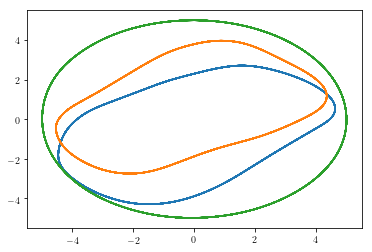

In [533]:
k=350#(188,205):[2.038,2.055],(294,301):[2.144,2.151],(304,):[2.154,]
i=1658+k*10
print(rhoLClikeCb_16842_2580[i])
plt.plot(LClikeCb_x_16842_2580[i],LClikeCb_y_16842_2580[i])
rhos2=np.round(np.linspace(1.85,2.50,len(newLC_x_rho_185_250)),6)
j=0+k
print(rhos2[j])
plt.plot(newLC_x_rho_185_250[j],newLC_y_rho_185_250[j])
l=549+k*1
print(rhoCb_1301_2497[l])
plt.plot(Cb_x_rho_1301_2497[l],Cb_y_rho_1301_2497[l])

1.64
1.64


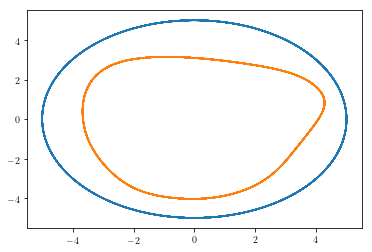

In [392]:
k=24#(188,205):[2.038,2.055],(294,301):[2.144,2.151],(304,):[2.154,]
i=k*100
print(rhoNewLC2_1400_1700[i])
plt.plot(NewLC2_x_1400_1700[i],NewLC2_y_1400_1700[i])
rhos1=np.round(np.linspace(1.00,1.85,len(newLC_x_rho_185_100)),6)
j=40+k
print(rhos1[j])
plt.plot(newLC_x_rho_185_100[j],newLC_y_rho_185_100[j])

In [403]:
k1=188
i=1658+k1*10
k2=205
l=1658+k2*10
rhoLClikeCb_1=rhoLClikeCb_16842_2580[i:l+1]
LClikeCb_x_1=LClikeCb_x_16842_2580[i:l+1]
LClikeCb_y_1=LClikeCb_y_16842_2580[i:l+1]
rhoLClikeCb_1

array([2.038 , 2.0381, 2.0382, 2.0383, 2.0384, 2.0385, 2.0386, 2.0387,
       2.0388, 2.0389, 2.039 , 2.0391, 2.0392, 2.0393, 2.0394, 2.0395,
       2.0396, 2.0397, 2.0398, 2.0399, 2.04  , 2.0401, 2.0402, 2.0403,
       2.0404, 2.0405, 2.0406, 2.0407, 2.0408, 2.0409, 2.041 , 2.0411,
       2.0412, 2.0413, 2.0414, 2.0415, 2.0416, 2.0417, 2.0418, 2.0419,
       2.042 , 2.0421, 2.0422, 2.0423, 2.0424, 2.0425, 2.0426, 2.0427,
       2.0428, 2.0429, 2.043 , 2.0431, 2.0432, 2.0433, 2.0434, 2.0435,
       2.0436, 2.0437, 2.0438, 2.0439, 2.044 , 2.0441, 2.0442, 2.0443,
       2.0444, 2.0445, 2.0446, 2.0447, 2.0448, 2.0449, 2.045 , 2.0451,
       2.0452, 2.0453, 2.0454, 2.0455, 2.0456, 2.0457, 2.0458, 2.0459,
       2.046 , 2.0461, 2.0462, 2.0463, 2.0464, 2.0465, 2.0466, 2.0467,
       2.0468, 2.0469, 2.047 , 2.0471, 2.0472, 2.0473, 2.0474, 2.0475,
       2.0476, 2.0477, 2.0478, 2.0479, 2.048 , 2.0481, 2.0482, 2.0483,
       2.0484, 2.0485, 2.0486, 2.0487, 2.0488, 2.0489, 2.049 , 2.0491,
      

In [404]:
k1=294
i=1658+k1*10
#k2=301
#l=1658+k2*10
rhoLClikeCb_2=rhoLClikeCb_16842_2580[i:-800]
LClikeCb_x_2=LClikeCb_x_16842_2580[i:-800]
LClikeCb_y_2=LClikeCb_y_16842_2580[i:-800]
rhoLClikeCb_2

array([2.144 , 2.1441, 2.1442, ..., 2.4998, 2.4999, 2.5   ])

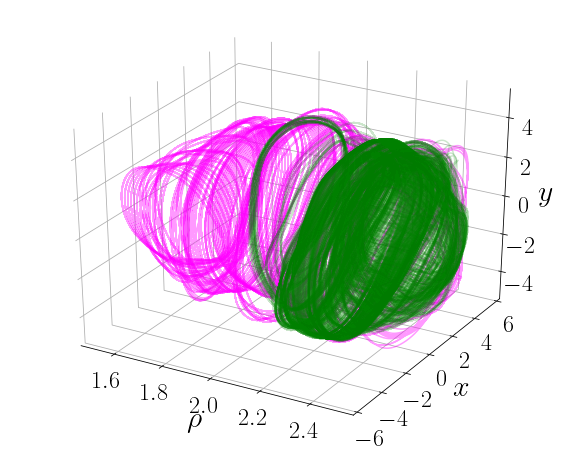

In [393]:
alph=0.4
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(1,1)
ax = fig.add_subplot(gs[0,0],projection='3d')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

rhos1=np.round(np.linspace(1.00,1.85,len(newLC_x_rho_185_100)),6)
rhos2=np.round(np.linspace(1.85,2.50,len(newLC_x_rho_185_250)),6)
for i in range(53,len(newLC_x_rho_185_100),1):
    ax.plot(rhos1[i]*np.ones(len(newLC_x_rho_185_100[i])),newLC_x_rho_185_100[i],newLC_y_rho_185_100[i],'fuchsia',alpha=alph)
for i in range(1,len(newLC_x_rho_185_250),10):
    ax.plot(rhos2[i]*np.ones(len(newLC_x_rho_185_250[i])),newLC_x_rho_185_250[i],newLC_y_rho_185_250[i],'fuchsia',alpha=alph)

for i in range(0,len(rhoLClikeCb_1),10):
    ax.plot(rhoLClikeCb_1[i]*np.ones(len(LClikeCb_x_1[i])),LClikeCb_x_1[i],LClikeCb_y_1[i],'green',alpha=0.5*alph)
for i in range(0,len(rhoLClikeCb_2),10):
    ax.plot(rhoLClikeCb_2[i]*np.ones(len(LClikeCb_x_2[i])),LClikeCb_x_2[i],LClikeCb_y_2[i],'green',alpha=0.5*alph)
    
ax.xaxis.set_rotate_label(False)
ax.set_xlabel(r'$\rho$',fontsize=30,rotation=0,labelpad=10)
ax.set_ylabel(r'$x$',fontsize=30,labelpad=10)
ax.set_zlabel(r'$y$',fontsize=30)

ax.tick_params(axis='both',labelsize=24)
    
plt.show()

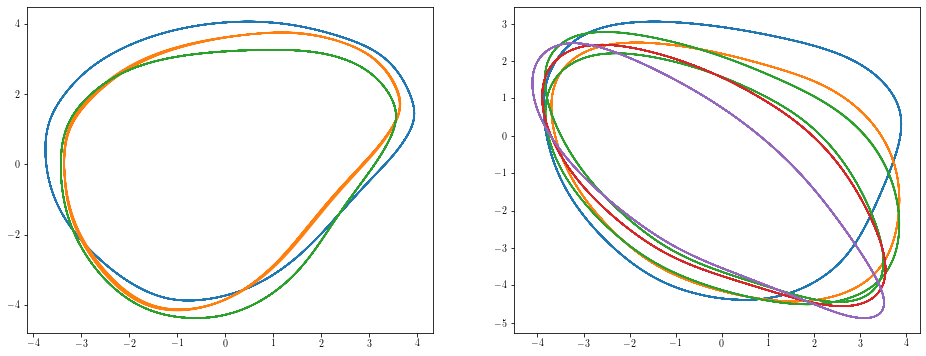

In [571]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(newLC_x_rho_185_250[0],newLC_y_rho_185_250[0])
plt.plot(newLC_x_rho_185_100[-10],newLC_y_rho_185_100[-10])
plt.plot(newLC_x_rho_185_100[-17],newLC_y_rho_185_100[-17])
plt.subplot(1,2,2)
plt.plot(newLC_x_rho_185_100[-18],newLC_y_rho_185_100[-18])
plt.plot(newLC_x_rho_185_100[-24],newLC_y_rho_185_100[-24])
plt.plot(newLC_x_rho_185_100[-27],newLC_y_rho_185_100[-27])
plt.plot(newLC_x_rho_185_100[-28],newLC_y_rho_185_100[-28])
plt.plot(newLC_x_rho_185_100[-33],newLC_y_rho_185_100[-33])

In [574]:
rhos1[-33],rhos1[-18]

(1.53, 1.68)

In [537]:
rhos1,rhos2[::10]

(array([1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1 ,
        1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 , 1.21,
        1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31, 1.32,
        1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42, 1.43,
        1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5 , 1.51, 1.52, 1.53, 1.54,
        1.55, 1.56, 1.57, 1.58, 1.59, 1.6 , 1.61, 1.62, 1.63, 1.64, 1.65,
        1.66, 1.67, 1.68, 1.69, 1.7 , 1.71, 1.72, 1.73, 1.74, 1.75, 1.76,
        1.77, 1.78, 1.79, 1.8 , 1.81, 1.82, 1.83, 1.84, 1.85]),
 array([1.85, 1.86, 1.87, 1.88, 1.89, 1.9 , 1.91, 1.92, 1.93, 1.94, 1.95,
        1.96, 1.97, 1.98, 1.99, 2.  , 2.01, 2.02, 2.03, 2.04, 2.05, 2.06,
        2.07, 2.08, 2.09, 2.1 , 2.11, 2.12, 2.13, 2.14, 2.15, 2.16, 2.17,
        2.18, 2.19, 2.2 , 2.21, 2.22, 2.23, 2.24, 2.25, 2.26, 2.27, 2.28,
        2.29, 2.3 , 2.31, 2.32, 2.33, 2.34, 2.35, 2.36, 2.37, 2.38, 2.39,
        2.4 , 2.41, 2.42, 2.43, 2.44, 2.45, 2.46

In [528]:
rhos1[i]

1.85

841
0.7765


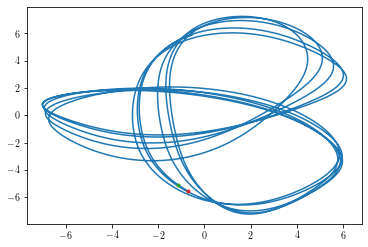

In [427]:
rhos=np.round(np.linspace(0.70,0.784,len(LCp2_y_rho_0784_0700)),6)
print(len(LCp2_y_rho_0784_0700))
h=765#345
print(rhos[h])
plt.plot(LCp2_x_rho_0784_0700[h],LCp2_y_rho_0784_0700[h])
plt.plot(LCp2_x_rho_0784_0700[h][-10],LCp2_y_rho_0784_0700[h][-10],'C2.')
plt.plot(LCp2_x_rho_0784_0700[h][-1],LCp2_y_rho_0784_0700[h][-1],'C3.')

1001
0.8017


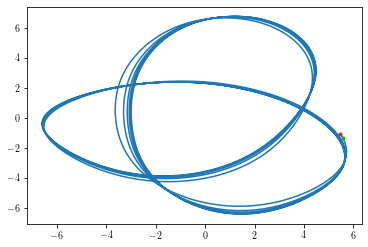

In [425]:
rhos=np.round(np.linspace(0.784,0.884,len(LCp2_y_rho_0784_0884)),6)
print(len(LCp2_y_rho_0784_0884))
h=177#345
print(rhos[h])
plt.plot(LCp2_x_rho_0784_0884[h],LCp2_y_rho_0784_0884[h])
plt.plot(LCp2_x_rho_0784_0884[h][-10],LCp2_y_rho_0784_0884[h][-10],'C2.')
plt.plot(LCp2_x_rho_0784_0884[h][-1],LCp2_y_rho_0784_0884[h][-1],'C3.')

In [405]:
LCp2_x_rho_07765_08017=np.vstack((LCp2_x_rho_0784_0700[765:],LCp2_x_rho_0784_0884[1:177]))
LCp2_y_rho_07765_08017=np.vstack((LCp2_y_rho_0784_0700[765:],LCp2_y_rho_0784_0884[1:177]))
rhoLCsnip_07765_08017=np.round(np.linspace(0.7765,0.8016,len(LCp2_y_rho_07765_08017)),6)

501
0.8


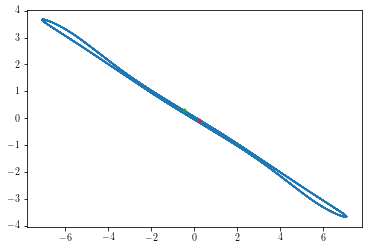

In [319]:
rhos=np.round(np.linspace(0.75,0.80,len(LCsnip_x_rho_075_080)),6)
print(len(LCsnip_x_rho_075_080))
h=-1#337
print(rhos[h])
plt.plot(LCsnip_x_rho_075_080[h],LCsnip_y_rho_075_080[h])
plt.plot(LCsnip_x_rho_075_080[h][-10],LCsnip_y_rho_075_080[h][-10],'C2.')
plt.plot(LCsnip_x_rho_075_080[h][-1],LCsnip_y_rho_075_080[h][-1],'C3.')

501
0.848


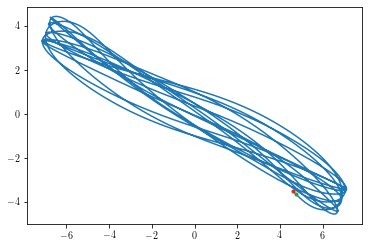

In [325]:
rhos=np.round(np.linspace(0.80,0.85,len(LCsnip_x_rho_080_085)),6)
print(len(LCsnip_x_rho_080_085))
h=480#337
print(rhos[h])
plt.plot(LCsnip_x_rho_080_085[h],LCsnip_y_rho_080_085[h])
plt.plot(LCsnip_x_rho_080_085[h][-10],LCsnip_y_rho_080_085[h][-10],'C2.')
plt.plot(LCsnip_x_rho_080_085[h][-1],LCsnip_y_rho_080_085[h][-1],'C3.')

In [406]:
LCsnip_x_rho_07337_08480=np.vstack((LCsnip_x_rho_075_070[337:],LCsnip_x_rho_075_080[1:],LCsnip_x_rho_080_085[1:480]))
LCsnip_y_rho_07337_08480=np.vstack((LCsnip_y_rho_075_070[337:],LCsnip_y_rho_075_080[1:],LCsnip_y_rho_080_085[1:480]))
rhoLCsnip_07337_08480=np.round(np.linspace(0.7337,0.8479,len(LCsnip_x_rho_07337_08480)),6)

In [329]:
rhoLCsnip_07337_08480[100:200],len(LCsnip_x_rho_07337_08480)

(array([0.7437, 0.7438, 0.7439, 0.744 , 0.7441, 0.7442, 0.7443, 0.7444,
        0.7445, 0.7446, 0.7447, 0.7448, 0.7449, 0.745 , 0.7451, 0.7452,
        0.7453, 0.7454, 0.7455, 0.7456, 0.7457, 0.7458, 0.7459, 0.746 ,
        0.7461, 0.7462, 0.7463, 0.7464, 0.7465, 0.7466, 0.7467, 0.7468,
        0.7469, 0.747 , 0.7471, 0.7472, 0.7473, 0.7474, 0.7475, 0.7476,
        0.7477, 0.7478, 0.7479, 0.748 , 0.7481, 0.7482, 0.7483, 0.7484,
        0.7485, 0.7486, 0.7487, 0.7488, 0.7489, 0.749 , 0.7491, 0.7492,
        0.7493, 0.7494, 0.7495, 0.7496, 0.7497, 0.7498, 0.7499, 0.75  ,
        0.7501, 0.7502, 0.7503, 0.7504, 0.7505, 0.7506, 0.7507, 0.7508,
        0.7509, 0.751 , 0.7511, 0.7512, 0.7513, 0.7514, 0.7515, 0.7516,
        0.7517, 0.7518, 0.7519, 0.752 , 0.7521, 0.7522, 0.7523, 0.7524,
        0.7525, 0.7526, 0.7527, 0.7528, 0.7529, 0.753 , 0.7531, 0.7532,
        0.7533, 0.7534, 0.7535, 0.7536]),
 1143)

1201
2.497


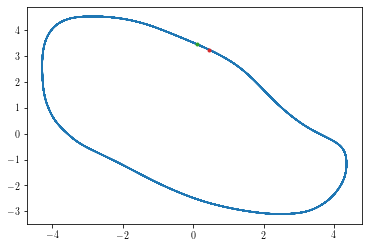

In [169]:
rhos=np.round(np.linspace(1.30,2.50,len(Cb_x_rho_130_250)),6)
print(len(Cb_x_rho_130_250))
h=1197
print(rhos[h])
plt.plot(Cb_x_rho_130_250[h],Cb_y_rho_130_250[h])
plt.plot(Cb_x_rho_130_250[h][-10],Cb_y_rho_130_250[h][-10],'C2.')
plt.plot(Cb_x_rho_130_250[h][-1],Cb_y_rho_130_250[h][-1],'C3.')

401
1.2955


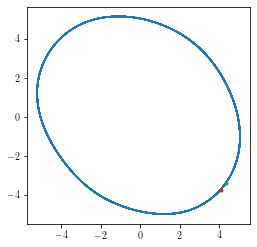

In [134]:
plt.figure(figsize=(4,4))
rhos=np.round(np.linspace(1.26,1.30,len(Cb_y_rho_130_126)),6)
print(len(Cb_y_rho_130_126))
h=355
print(rhos[h])
plt.plot(Cb_x_rho_130_126[h],Cb_y_rho_130_126[h])
plt.plot(Cb_x_rho_130_126[h][-10],Cb_y_rho_130_126[h][-10],'C2.')
plt.plot(Cb_x_rho_130_126[h][-1],Cb_y_rho_130_126[h][-1],'C3.')

101
0.7901


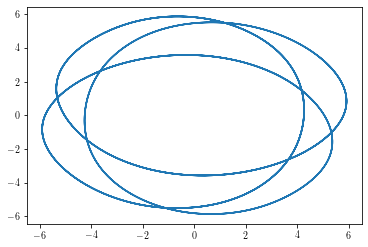

In [42]:
rhos=np.round(np.linspace(.79,.80,len(Ca_y_rho_080_079)),6)
print(len(Ca_y_rho_080_079))
h=1
print(rhos[h])
plt.plot(Ca_x_rho_080_079[h],Ca_y_rho_080_079[h])
#plt.plot(newLC_x_rho_185_100[h],newLC_y_rho_185_100[h])
#print([trajsavex_r4[h],trajsavey_r4[h]])

301
0.83


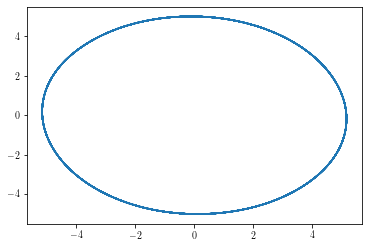

In [65]:
rhos=np.round(np.linspace(.80,.83,len(Ca_x_rho_080_083)),6)
print(len(Ca_x_rho_080_083))
h=-1
print(rhos[h])
plt.plot(Ca_x_rho_080_083[h],Ca_y_rho_080_083[h])
#plt.plot(newLC_x_rho_185_100[h],newLC_y_rho_185_100[h])
#print([trajsavex_r4[h],trajsavey_r4[h]])

1701
0.831


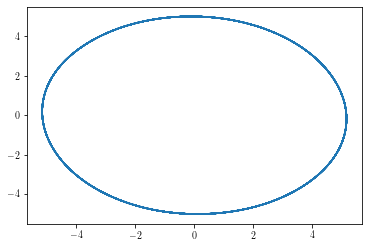

In [48]:
rhos=np.round(np.linspace(.80,2.50,len(Ca_x_rho_080_250)),6)
print(len(Ca_x_rho_080_250))
h=31
print(rhos[h])
plt.plot(Ca_x_rho_080_250[h],Ca_y_rho_080_250[h])
#plt.plot(newLC_x_rho_185_100[h],newLC_y_rho_185_100[h])
#print([trajsavex_r4[h],trajsavey_r4[h]])

1701
2.081


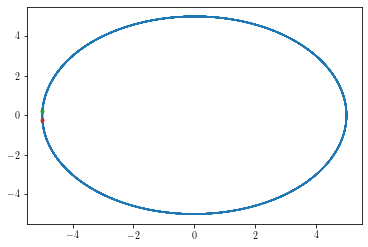

In [77]:
rhos=np.round(np.linspace(.80,2.50,len(Ca_x_rho_080_250)),6)
print(len(Ca_x_rho_080_250))
h=1281#31#1281
print(rhos[h])
plt.plot(Ca_x_rho_080_250[h],Ca_y_rho_080_250[h])
plt.plot(Ca_x_rho_080_250[h][-10],Ca_y_rho_080_250[h][-10],'C2.')
plt.plot(Ca_x_rho_080_250[h][-1],Ca_y_rho_080_250[h][-1],'C3.')
#plt.plot(newLC_x_rho_185_100[h],newLC_y_rho_185_100[h])
#print([trajsavex_r4[h],trajsavey_r4[h]])

In [62]:
Ca_x_rho_080_083[1:]

array([[ 1.24230715e+00,  1.19298905e+00,  1.14354997e+00, ...,
        -1.10032946e+00, -1.14570054e+00, -1.19093613e+00],
       [ 4.29217526e+00,  4.27243498e+00,  4.25214579e+00, ...,
         2.56967421e+00,  2.52806524e+00,  2.48627185e+00],
       [ 4.54825310e+00,  4.56672079e+00,  4.58469115e+00, ...,
         5.04771571e+00,  5.02909310e+00,  5.01000282e+00],
       ...,
       [ 2.14273831e+00,  2.19081814e+00,  2.23867243e+00, ...,
         5.15485171e+00,  5.15270229e+00,  5.15004515e+00],
       [ 4.83722430e+00,  4.85501062e+00,  4.87229726e+00, ...,
         3.60905392e+00,  3.57255622e+00,  3.53570414e+00],
       [ 4.72651921e+00,  4.70608901e+00,  4.68520830e+00, ...,
         2.99871577e-03, -4.95397757e-02, -1.02087682e-01]])

1.5


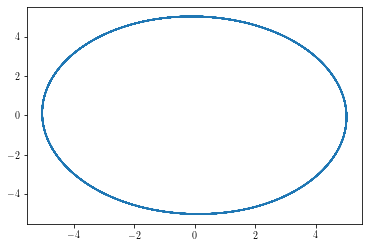

In [41]:
rhos=np.round(np.linspace(1.00,1.85,len(newLC_x_rho_185_100)),6)
h=50
print(rhos[h])
plt.plot(newLC_x_rho_185_100[h],newLC_y_rho_185_100[h])
#plt.plot(newLC_x_rho_185_100[h],newLC_y_rho_185_100[h])
#print([trajsavex_r4[h],trajsavey_r4[h]])

1.75


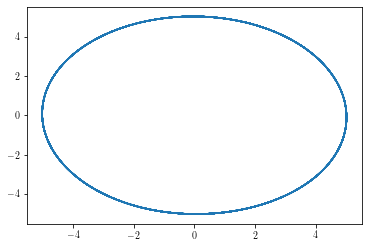

In [47]:
rhos=np.round(np.linspace(1.20,1.85,len(newLC_x_rho_185_120)),6)
h=550
print(rhos[h])
plt.plot(newLC_x_rho_185_120[h],newLC_y_rho_185_120[h])
#plt.plot(newLC_x_rho_185_100[h],newLC_y_rho_185_100[h])
#print([trajsavex_r4[h],trajsavey_r4[h]])

0.7857


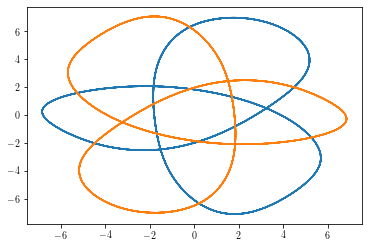

In [41]:
rhos=np.round(np.linspace(0.784,0.884,len(trajsavex_r11)),6)
h=17
print(rhos[h])
plt.plot(trajsavex_r11[h],trajsavey_r11[h])
plt.plot(trajsavex_r12[h],trajsavey_r12[h])
#print([trajsavex_r4[h],trajsavey_r4[h]])

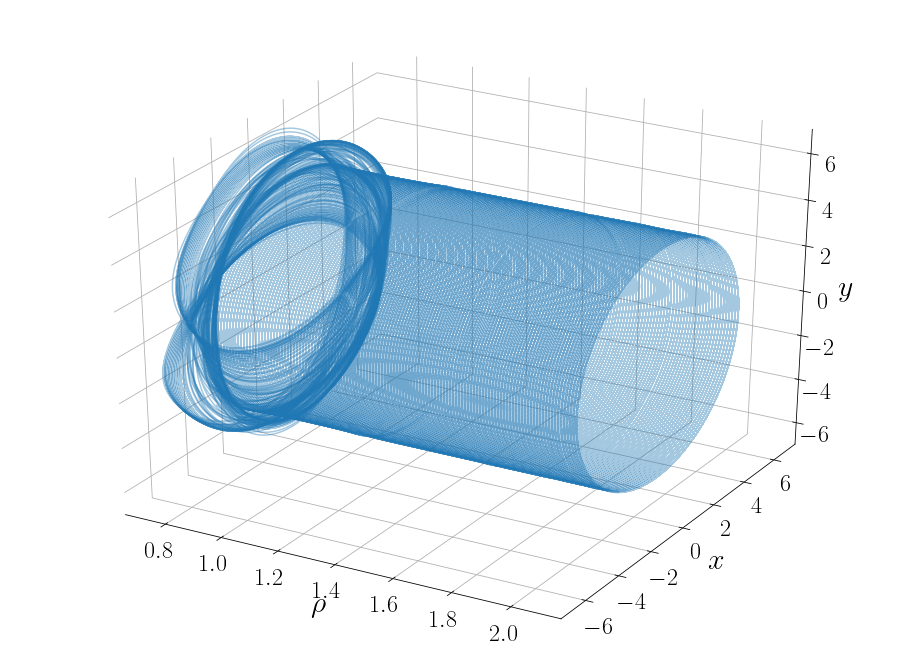

In [407]:
alph=0.4
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(1,1)
ax = fig.add_subplot(gs[0,0],projection='3d')

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

for i in range(0,len(Ca_x_rho_07522_08300),30):
#for i in range(len(Ca_x_rho_07522_08300)):
    ax.plot(rhoCa_07522_08300[i]*np.ones(len(Ca_x_rho_07522_08300[i])),Ca_x_rho_07522_08300[i],Ca_y_rho_07522_08300[i],'C0',alpha=alph)
#for i in range(len(Ca_x_rho_0831_2081)):
for i in range(0,len(Ca_x_rho_0831_2081),10):
    ax.plot(rhoCa_0831_2081[i]*np.ones(len(Ca_x_rho_0831_2081[i])),Ca_x_rho_0831_2081[i],Ca_y_rho_0831_2081[i],'C0',alpha=alph)

ax.xaxis.set_rotate_label(False)
ax.set_xlabel(r'$\rho$',fontsize=30,rotation=0,labelpad=10)
ax.set_ylabel(r'$x$',fontsize=30,labelpad=10)
ax.set_zlabel(r'$y$',fontsize=30)

ax.tick_params(axis='both',labelsize=24)

plt.show()

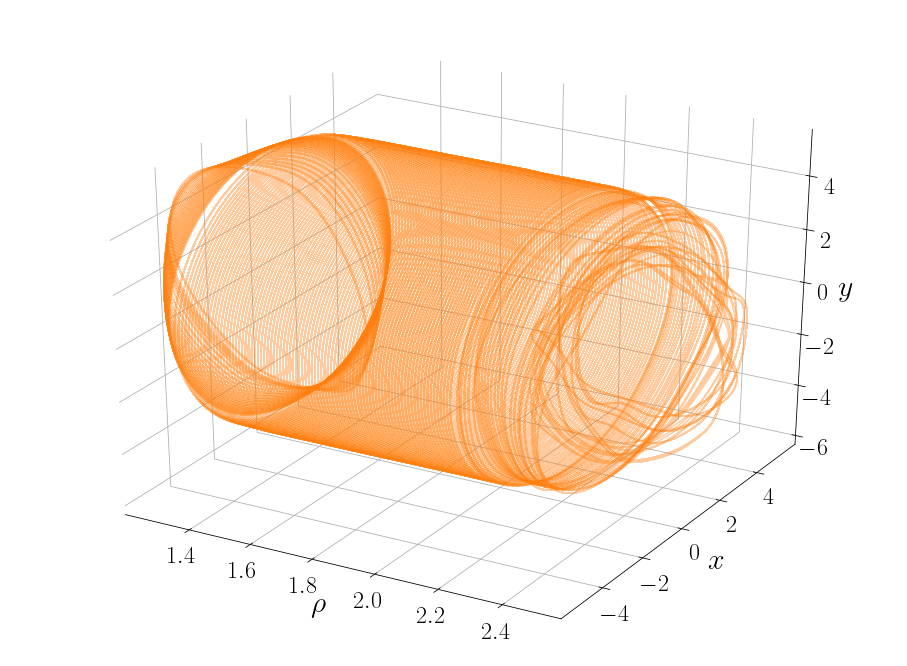

In [408]:
alph=0.4
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(1,1)
ax = fig.add_subplot(gs[0,0],projection='3d')

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

for i in range(0,len(Cb_x_rho_12769_13000),10):
#for i in range(len(Ca_x_rho_07522_08300)):
    ax.plot(rhoCb_12769_13000[i]*np.ones(len(Cb_x_rho_12769_13000[i])),Cb_x_rho_12769_13000[i],Cb_y_rho_12769_13000[i],'C1',alpha=alph)
#for i in range(len(Ca_x_rho_0831_2081)):
for i in range(0,len(Cb_x_rho_1301_2497),10):
    ax.plot(rhoCb_1301_2497[i]*np.ones(len(Cb_x_rho_1301_2497[i])),Cb_x_rho_1301_2497[i],Cb_y_rho_1301_2497[i],'C1',alpha=alph)

ax.xaxis.set_rotate_label(False)
ax.set_xlabel(r'$\rho$',fontsize=30,rotation=0,labelpad=10)
ax.set_ylabel(r'$x$',fontsize=30,labelpad=10)
ax.set_zlabel(r'$y$',fontsize=30)

ax.tick_params(axis='both',labelsize=24)
    
plt.show()

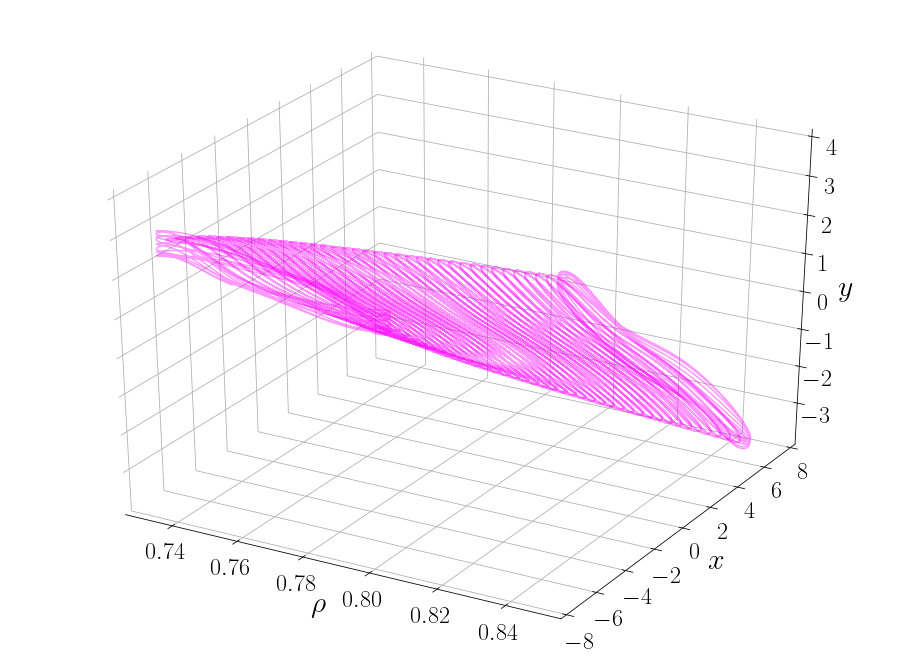

In [409]:
alph=0.4
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(1,1)
ax = fig.add_subplot(gs[0,0],projection='3d')

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

for i in range(0,len(LCsnip_x_rho_07337_08480),30):
    ax.plot(rhoLCsnip_07337_08480[i]*np.ones(len(LCsnip_x_rho_07337_08480[i])),LCsnip_x_rho_07337_08480[i],LCsnip_y_rho_07337_08480[i],'fuchsia',alpha=alph)

ax.xaxis.set_rotate_label(False)
ax.set_xlabel(r'$\rho$',fontsize=30,rotation=0,labelpad=10)
ax.set_ylabel(r'$x$',fontsize=30,labelpad=10)
ax.set_zlabel(r'$y$',fontsize=30)

ax.tick_params(axis='both',labelsize=24)
    
plt.show()

In [ ]:
LCp2_x_rho_07765_08017=np.vstack((LCp2_x_rho_0784_0700[765:],LCp2_x_rho_0784_0884[1:177]))
LCp2_y_rho_07765_08017=np.vstack((LCp2_y_rho_0784_0700[765:],LCp2_y_rho_0784_0884[1:177]))
rhoLCsnip_07765_08017=np.round(np.linspace(0.7765,0.8016,len(LCp2_y_rho_07765_08017)),6)

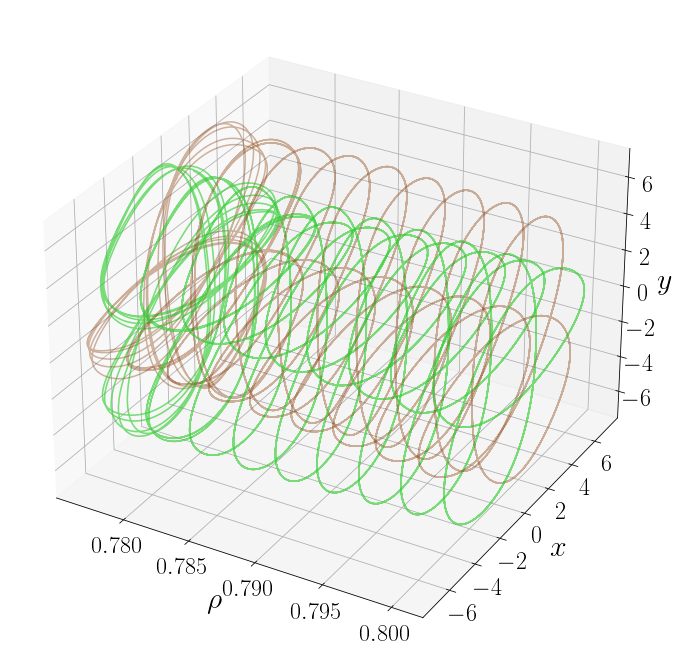

In [442]:
alph=0.4
fig = plt.figure(figsize=(16, 12))
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
gs = gridspec.GridSpec(1,1)
ax = fig.add_subplot(gs[0,0],projection='3d')

for i in range(0,len(LCp2_x_rho_07765_08017),30):
    ax.plot(rhoLCsnip_07765_08017[i]*np.ones(len(LCp2_x_rho_07765_08017[i])),-LCp2_x_rho_07765_08017[i],-LCp2_y_rho_07765_08017[i],'limegreen',alpha=alph)
    ax.plot(rhoLCsnip_07765_08017[i]*np.ones(len(LCp2_x_rho_07765_08017[i])),LCp2_x_rho_07765_08017[i],LCp2_y_rho_07765_08017[i],'saddlebrown',alpha=alph)
    ax.plot(rhoLCsnip_07765_08017[i]*np.ones(len(LCp2_x_rho_07765_08017[i])),-LCp2_x_rho_07765_08017[i],-LCp2_y_rho_07765_08017[i],'limegreen',alpha=alph)

ax.xaxis.set_rotate_label(False)
ax.set_xlabel(r'$\rho$',fontsize=30,rotation=0,labelpad=10)
ax.set_ylabel(r'$x$',fontsize=30,labelpad=10)
ax.set_zlabel(r'$y$',fontsize=30)

ax.tick_params(axis='both',labelsize=24)
    
plt.show()

In [521]:
rhoCb_1301_2497[-270]

2.2277

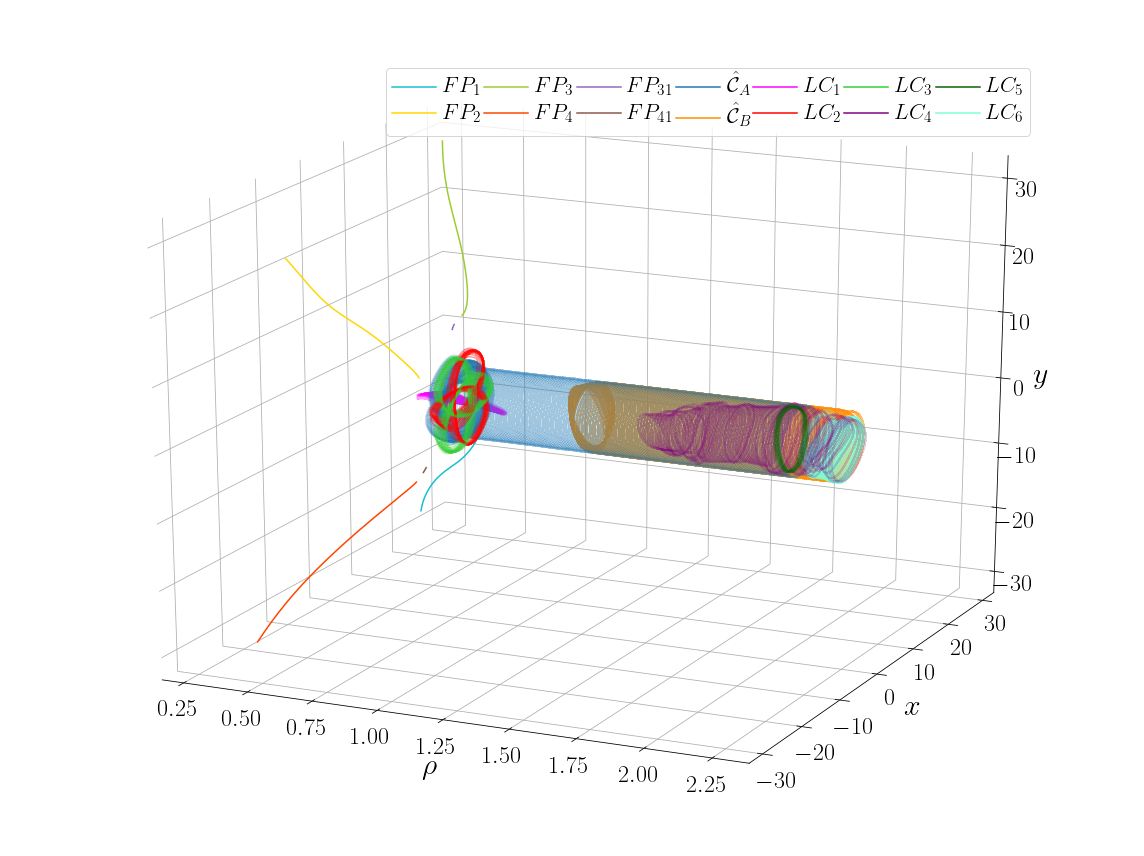

In [42]:
alph=0.4
alph1=0.2
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(1,1)
ax = fig.add_subplot(gs[0,0],projection='3d')

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

fpstart=30
#print(FP_pp.T[0][fpstart])

ax.plot(FP_np.T[0][fpstart:],-FP_np.T[2][fpstart:],-FP_np.T[3][fpstart:],'C9',label=r'$FP_{1}$')
ax.plot(FP_np.T[0][fpstart:],FP_np.T[2][fpstart:],FP_np.T[3][fpstart:],'gold',label=r'$FP_{2}$')

ax.plot(FP_pp.T[0][fpstart:],FP_pp.T[2][fpstart:],FP_pp.T[3][fpstart:],'yellowgreen',label=r'$FP_{3}$')
ax.plot(FP_pp.T[0][fpstart:],-FP_pp.T[2][fpstart:],-FP_pp.T[3][fpstart:],'orangered',label=r'$FP_{4}$')

ax.plot(FP_pp_small.T[0][fpstart:],FP_pp_small.T[2][fpstart:],FP_pp_small.T[3][fpstart:],'C4',label=r'$FP_{31}$')
ax.plot(FP_pp_small.T[0][fpstart:],-FP_pp_small.T[2][fpstart:],-FP_pp_small.T[3][fpstart:],'C5',label=r'$FP_{41}$')


for i in range(0,len(Cb_x_rho_12769_13000),10):
#for i in range(len(Ca_x_rho_07522_08300)):
    ax.plot(rhoCb_12769_13000[i]*np.ones(len(Cb_x_rho_12769_13000[i])),Cb_x_rho_12769_13000[i],Cb_y_rho_12769_13000[i],'darkorange',alpha=1.4*alph)
#for i in range(len(Ca_x_rho_0831_2081)):
for i in range(0,len(Cb_x_rho_1301_2497[:-240]),10):
    ax.plot(rhoCb_1301_2497[i]*np.ones(len(Cb_x_rho_1301_2497[i])),Cb_x_rho_1301_2497[i],Cb_y_rho_1301_2497[i],'darkorange',alpha=1.4*alph)

for i in range(0,len(rhoLClikeCb_2[:-2430]),10):
    ax.plot(rhoLClikeCb_2[i]*np.ones(len(LClikeCb_x_2[i])),LClikeCb_x_2[i],LClikeCb_y_2[i],'aquamarine',alpha=0.5*alph)
    
for i in range(0,len(LCsnip_x_rho_07337_08480),30):
    ax.plot(rhoLCsnip_07337_08480[i]*np.ones(len(LCsnip_x_rho_07337_08480[i])),LCsnip_x_rho_07337_08480[i],LCsnip_y_rho_07337_08480[i],'fuchsia',alpha=alph)

for i in range(0,len(Ca_x_rho_07522_08300),30):
#for i in range(len(Ca_x_rho_07522_08300)):
    ax.plot(rhoCa_07522_08300[i]*np.ones(len(Ca_x_rho_07522_08300[i])),Ca_x_rho_07522_08300[i],Ca_y_rho_07522_08300[i],'C0',alpha=1.2*alph1)
#for i in range(len(Ca_x_rho_0831_2081)):
for i in range(0,len(Ca_x_rho_0831_2081),10):
    ax.plot(rhoCa_0831_2081[i]*np.ones(len(Ca_x_rho_0831_2081[i])),Ca_x_rho_0831_2081[i],Ca_y_rho_0831_2081[i],'C0',alpha=1.2*alph1)

ax.plot(rhoCa_0831_2081[-1]*np.ones(len(Ca_x_rho_0831_2081[-1])),Ca_x_rho_0831_2081[-1],Ca_y_rho_0831_2081[-1],'C0',alpha=1.9*alph1)

for i in range(0,len(LCp2_x_rho_07765_08017),30):
    ax.plot(rhoLCsnip_07765_08017[i]*np.ones(len(LCp2_x_rho_07765_08017[i])),LCp2_x_rho_07765_08017[i],LCp2_y_rho_07765_08017[i],'red',alpha=alph)
    ax.plot(rhoLCsnip_07765_08017[i]*np.ones(len(LCp2_x_rho_07765_08017[i])),-LCp2_x_rho_07765_08017[i],-LCp2_y_rho_07765_08017[i],'limegreen',alpha=alph)
    
rhos1=np.round(np.linspace(1.00,1.85,len(newLC_x_rho_185_100)),6)
rhos2=np.round(np.linspace(1.85,2.50,len(newLC_x_rho_185_250)),6)
for i in range(53,len(newLC_x_rho_185_100),1):
    ax.plot(rhos1[i]*np.ones(len(newLC_x_rho_185_100[i])),newLC_x_rho_185_100[i],newLC_y_rho_185_100[i],'purple',alpha=0.5*alph)
for i in range(1,len(newLC_x_rho_185_250[:-234]),10):
    ax.plot(rhos2[i]*np.ones(len(newLC_x_rho_185_250[i])),newLC_x_rho_185_250[i],newLC_y_rho_185_250[i],'purple',alpha=0.5*alph)
    
for i in range(0,len(rhoLClikeCb_1),10):
    ax.plot(rhoLClikeCb_1[i]*np.ones(len(LClikeCb_x_1[i])),LClikeCb_x_1[i],LClikeCb_y_1[i],'darkgreen',alpha=0.3*alph)
    
i=0
ax.plot(-10*np.ones(len(Ca_x_rho_0831_2081[i])),Ca_x_rho_0831_2081[i],Ca_y_rho_0831_2081[i],'C0',label=r'$\hat{\mathcal{C}}_{A}$')
ax.plot(-10*np.ones(len(Cb_x_rho_12769_13000[i])),Cb_x_rho_12769_13000[i],Cb_y_rho_12769_13000[i],'darkorange',label=r'$\hat{\mathcal{C}}_{B}$')
ax.plot(-10*np.ones(len(LCsnip_x_rho_07337_08480[i])),LCsnip_x_rho_07337_08480[i],LCsnip_y_rho_07337_08480[i],'fuchsia',label=r'$LC_{1}$')
ax.plot(-10*np.ones(len(LCp2_x_rho_07765_08017[i])),LCp2_x_rho_07765_08017[i],LCp2_y_rho_07765_08017[i],'red',label=r'$LC_{2}$')
ax.plot(-10*np.ones(len(LCp2_x_rho_07765_08017[i])),-LCp2_x_rho_07765_08017[i],-LCp2_y_rho_07765_08017[i],'limegreen',label=r'$LC_{3}$')
ax.plot(-10*np.ones(len(newLC_x_rho_185_250[i])),newLC_x_rho_185_250[i],newLC_y_rho_185_250[i],'purple',label=r'$LC_{4}$')
ax.plot(-10*np.ones(len(LClikeCb_x_1[i])),LClikeCb_x_1[i],LClikeCb_y_1[i],'darkgreen',label=r'$LC_{5}$')
ax.plot(-10*np.ones(len(LClikeCb_x_2[i])),LClikeCb_x_2[i],LClikeCb_y_2[i],'aquamarine',label=r'$LC_{6}$')

ax.view_init(elev=20., azim=-65)
ax.set_xlim(0.21,2.34)
ax.set_ylim(-32,32)
ax.set_zlim(-32,32)

ax.xaxis.set_rotate_label(False)
ax.set_xlabel(r'$\rho$',fontsize=30,rotation=0,labelpad=15)
ax.set_ylabel(r'$x$',fontsize=30,labelpad=10)
ax.set_zlabel(r'$y$',fontsize=30)

#ax.legend(loc='upper center',ncol=6,handletextpad=0.3,columnspacing=.15,fontsize=22,bbox_to_anchor=(0.55,0.35))#bottom
ax.legend(loc='upper center',ncol=7,borderpad=0.3,labelspacing=0.3,
          handletextpad=0.3,columnspacing=.15,fontsize=22,bbox_to_anchor=(0.62,0.94))

ax.tick_params(axis='both',labelsize=24)
plt.tight_layout()
#plt.savefig("rho_bif_FFNN_v5.pdf",bbox_inches='tight',transparent=True)
    
plt.show()

In [612]:
rhoLClikeCb_2[-2431]

2.257

In [606]:
rhoCb_1301_2497[-241]

2.2567

In [610]:
rhos2[-231]

2.27

In [ ]:
'''    
rhos1=np.round(np.linspace(1.00,1.85,len(newLC_x_rho_185_100)),6)
rhos2=np.round(np.linspace(1.85,2.50,len(newLC_x_rho_185_250)),6)
for i in range(53,len(newLC_x_rho_185_100),1):
    ax.plot(rhos1[i]*np.ones(len(newLC_x_rho_185_100[i])),newLC_x_rho_185_100[i],newLC_y_rho_185_100[i],'fuchsia',alpha=alph)
for i in range(1,len(newLC_x_rho_185_250),10):
    ax.plot(rhos2[i]*np.ones(len(newLC_x_rho_185_250[i])),newLC_x_rho_185_250[i],newLC_y_rho_185_250[i],'fuchsia',alpha=alph)

for i in range(0,len(rhoLClikeCb_1),10):
    ax.plot(rhoLClikeCb_1[i]*np.ones(len(LClikeCb_x_1[i])),LClikeCb_x_1[i],LClikeCb_y_1[i],'green',alpha=0.5*alph)
for i in range(0,len(rhoLClikeCb_2),10):
    ax.plot(rhoLClikeCb_2[i]*np.ones(len(LClikeCb_x_2[i])),LClikeCb_x_2[i],LClikeCb_y_2[i],'green',alpha=0.5*alph)
'''

4.0


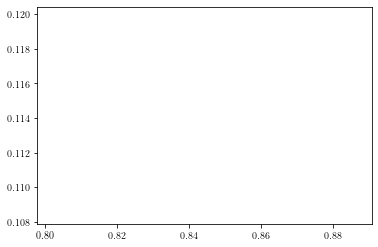

In [148]:
rhos=np.round(np.linspace(3.50,4.00,len(trajsavex_r6)),6)
h=-1
print(rhos[h])
plt.plot(trajsavex_r6[h],trajsavey_r6[h])
#print([trajsavex_r4[h],trajsavey_r4[h]])

3.0002


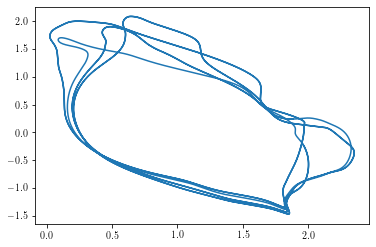

In [137]:
rhos=np.round(np.linspace(3.00,3.01,len(trajsavex_r5)),6)
h=10
print(rhos[h])
plt.plot(trajsavex_r5[h],trajsavey_r5[h])
#print([trajsavex_r4[h],trajsavey_r4[h]])

2.925


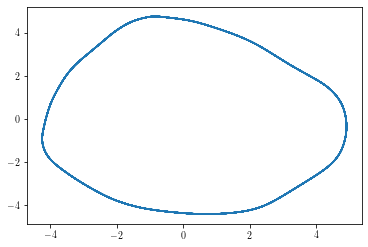

In [130]:
rhos=np.round(np.linspace(2.50,3.00,len(trajsavex_r4)),6)
h=425
print(rhos[h])
plt.plot(trajsavex_r4[h],trajsavey_r4[h])
#print([trajsavex_r4[h],trajsavey_r4[h]])

2.5


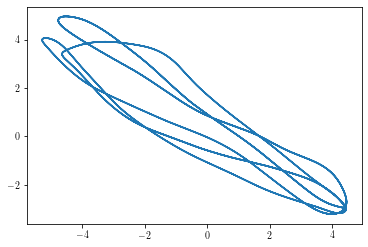

In [107]:
rhos=np.round(np.linspace(1.30,2.50,len(trajsavex_r3)),6)
h=-1
print(rhos[h])
plt.plot(trajsavex_r3[h],trajsavey_r3[h])
#plt.plot(-trajsavex_r[h],-trajsavey_r[h])

1.29


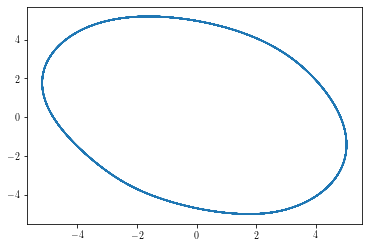

In [71]:
rhos=np.round(np.linspace(1.30,1.26,len(trajsavex_r2)),6)
h=100
print(rhos[h])
plt.plot(trajsavex_r2[h],trajsavey_r2[h])
#plt.plot(-trajsavex_r[h],-trajsavey_r[h])

1.273


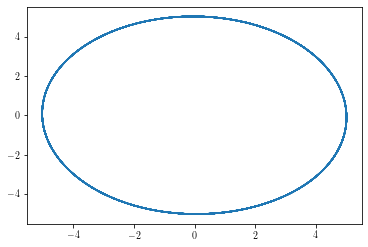

In [41]:
rhos=np.round(np.linspace(1.35,1.25,len(trajsavex_r)),6)
h=77
print(rhos[h])
plt.plot(trajsavex_r[h],trajsavey_r[h])
#plt.plot(-trajsavex_r[h],-trajsavey_r[h])

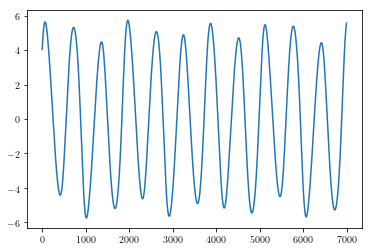

In [667]:
plt.plot(trajsavex_r[h])

0.753


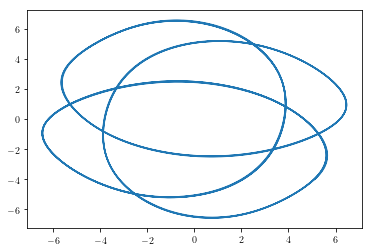

In [654]:
h=370
print(rhospace[h])
plt.plot(trajsavex_r1[h],trajsavey_r1[h])

In [551]:
trajsavex_r1,trajsavey_r1

(array([[ 5.1557555 ,  5.17087053,  5.18568337, ...,  3.42295984,
          3.47436011,  3.52534389],
        [-2.68773411, -2.71730872, -2.74653938, ..., -4.58134265,
         -4.60484151, -4.62806706],
        [ 5.59034588,  5.60869645,  5.62641954, ...,  1.49681484,
          1.53419779,  1.5714557 ],
        ...,
        [-1.40174707, -1.37952827, -1.35708804, ...,  3.23692244,
          3.23546645,  3.23395428],
        [-1.02437545, -0.9984363 , -0.97224229, ...,  3.20363975,
          3.20131406,  3.19894076],
        [-0.4894016 , -0.45815747, -0.42659516, ...,  3.14655326,
          3.14328651,  3.13997218]]),
 array([[ 5.1557555 ,  5.17087053,  5.18568337, ...,  3.42295984,
          3.47436011,  3.52534389],
        [-2.68773411, -2.71730872, -2.74653938, ..., -4.58134265,
         -4.60484151, -4.62806706],
        [ 5.59034588,  5.60869645,  5.62641954, ...,  1.49681484,
          1.53419779,  1.5714557 ],
        ...,
        [-1.40174707, -1.37952827, -1.35708804, ...,  

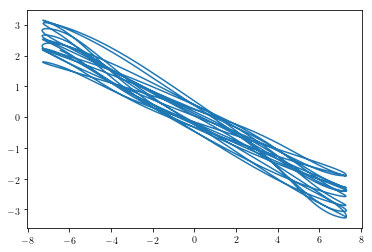

In [384]:
plt.plot(trajsave_r[67][2],trajsave_r[67][3])

In [387]:
len(trajsave_r[67][2])

7000

In [386]:
savedata('CAtrack_rho_080_083',np.array(trajsave))

ValueError: setting an array element with a sequence.

In [48]:
FP1_1 = loaddata('FP1_rho_02_06')
FP1_11 = loaddata('FP1_rho_06_07')
FP1_111 = loaddata('FP1_rho_068_072')
FP1_12 = loaddata('FP12_rho_070_066')
FP1_13 = loaddata('FP13_rho_071_076')
FP2_1 = loaddata('FP2_1')
FP2_1_new=loaddata('FP2_1_new_rho_02_7426')

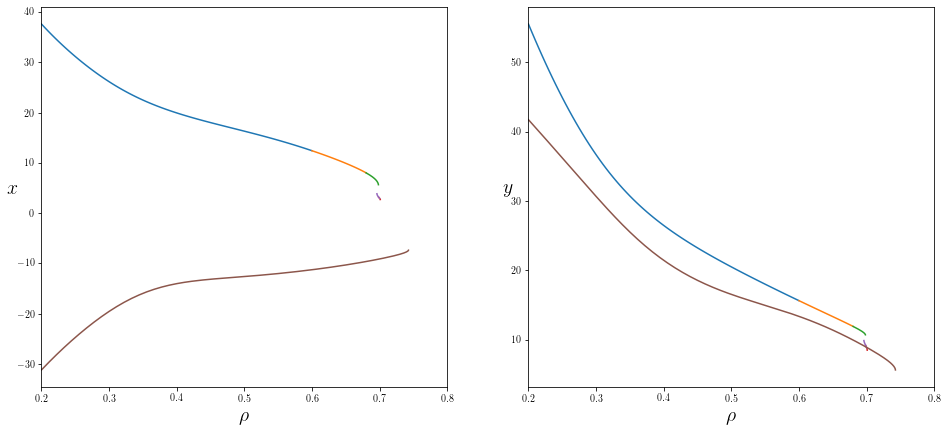

In [49]:
# Plot the FP data in 2d...
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.plot(FP1_1.T[0],FP1_1.T[2])
plt.plot(FP1_11.T[0][:81],FP1_11.T[2][:81])
plt.plot(FP1_111.T[0][:183],FP1_111.T[2][:183])

plt.plot(FP1_111.T[0][184:210],FP1_111.T[2][184:210])
plt.plot(FP1_12.T[0][:41],FP1_12.T[2][:41])

plt.plot(FP2_1_new.T[0],FP2_1_new.T[2])
plt.xlabel(r'$\rho$',fontsize=20)
plt.ylabel(r'$x$',fontsize=20,rotation=0)
plt.xlim(0.2,0.8)

plt.subplot(1,2,2)
plt.plot(FP1_1.T[0],FP1_1.T[3])
plt.plot(FP1_11.T[0][:81],FP1_11.T[3][:81])
plt.plot(FP1_111.T[0][:183],FP1_111.T[3][:183])

plt.plot(FP1_111.T[0][184:210],FP1_111.T[3][184:210])
plt.plot(FP1_12.T[0][:41],FP1_12.T[3][:41])

plt.plot(FP2_1_new.T[0],FP2_1_new.T[3])
plt.xlabel(r'$\rho$',fontsize=20)
plt.ylabel(r'$y$',fontsize=20,rotation=0)
plt.xlim(0.2,0.8)
plt.show()

In [73]:
#FP_pp_small=np.vstack((FP1_111[200:210][::-1],FP1_12[1:41]))
#savedata('FP_pp_small_rho_07009_06960',FP_pp_small)

In [54]:
#FP_pp=np.vstack((FP1_1,FP1_11[1:81],FP1_111[1:183]))
#savedata('FP_pp_rho_02_06982',FP_pp)

In [145]:
FP1_12.T[0][:41],FP1_111.T[0][184:210]

(array([0.7   , 0.6999, 0.6998, 0.6997, 0.6996, 0.6995, 0.6994, 0.6993,
        0.6992, 0.6991, 0.699 , 0.6989, 0.6988, 0.6987, 0.6986, 0.6985,
        0.6984, 0.6983, 0.6982, 0.6981, 0.698 , 0.6979, 0.6978, 0.6977,
        0.6976, 0.6975, 0.6974, 0.6973, 0.6972, 0.6971, 0.697 , 0.6969,
        0.6968, 0.6967, 0.6966, 0.6965, 0.6964, 0.6963, 0.6962, 0.6961,
        0.696 ]),
 array([0.6984, 0.6985, 0.6986, 0.6987, 0.6988, 0.6989, 0.699 , 0.6991,
        0.6992, 0.6993, 0.6994, 0.6995, 0.6996, 0.6997, 0.6998, 0.6999,
        0.7   , 0.7001, 0.7002, 0.7003, 0.7004, 0.7005, 0.7006, 0.7007,
        0.7008, 0.7009]))

In [109]:
FP2_1.T[0],FP1_13.T[0]

(array([0.2       , 0.20555556, 0.21111111, 0.21666667, 0.22222222,
        0.22777778, 0.23333333, 0.23888889, 0.24444444, 0.25      ,
        0.25555556, 0.26111111, 0.26666667, 0.27222222, 0.27777778,
        0.28333333, 0.28888889, 0.29444444, 0.3       , 0.30555556,
        0.31111111, 0.31666667, 0.32222222, 0.32777778, 0.33333333,
        0.33888889, 0.34444444, 0.35      , 0.35555556, 0.36111111,
        0.36666667, 0.37222222, 0.37777778, 0.38333333, 0.38888889,
        0.39444444, 0.4       , 0.40555556, 0.41111111, 0.41666667,
        0.42222222, 0.42777778, 0.43333333, 0.43888889, 0.44444444,
        0.45      , 0.45555556, 0.46111111, 0.46666667, 0.47222222,
        0.47777778, 0.48333333, 0.48888889, 0.49444444, 0.5       ,
        0.50555556, 0.51111111, 0.51666667, 0.52222222, 0.52777778,
        0.53333333, 0.53888889, 0.54444444, 0.55      , 0.55555556,
        0.56111111, 0.56666667, 0.57222222, 0.57777778, 0.58333333,
        0.58888889, 0.59444444, 0.6       , 0.60

In [116]:
FP2_1[:92]

(array([[  0.2       ,   0.        ,  31.19580187, -41.71938705],
        [  0.20555556,   0.        ,  30.41471273, -41.11609941],
        [  0.21111111,   0.        ,  29.64974987, -40.50980531],
        [  0.21666667,   0.        ,  28.90079373, -39.9012292 ],
        [  0.22222222,   0.        ,  28.1676464 , -39.29086632],
        [  0.22777778,   0.        ,  27.45008289, -38.67903591],
        [  0.23333333,   0.        ,  26.74789345, -38.06593075],
        [  0.23888889,   0.        ,  26.06091737, -37.45166267],
        [  0.24444444,   0.        ,  25.38906895, -36.83630529],
        [  0.25      ,   0.        ,  24.73235538, -36.2199323 ],
        [  0.25555556,   0.        ,  24.09088758, -35.60265169],
        [  0.26111111,   0.        ,  23.46488429, -34.9846357 ],
        [  0.26666667,   0.        ,  22.85466969, -34.36614516],
        [  0.27222222,   0.        ,  22.26066561, -33.74754846],
        [  0.27777778,   0.        ,  21.68337865, -33.12933438],
        [ 

In [131]:
FP2_1_new=np.vstack((np.array([1,1,-1,-1]) * FP2_1[:92],FP1_13[:327]))

In [138]:
#savedata('FP2_1_new_rho_02_7426',FP2_1_new)

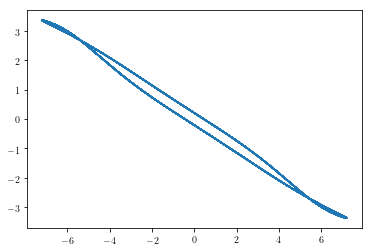

In [92]:
plt.plot(xpr1_13,xpr2_13)

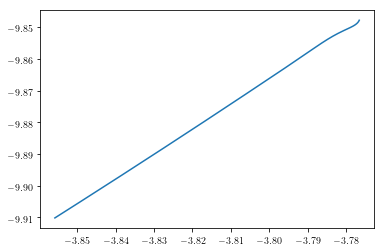

In [155]:
plt.plot(xpr1_12_1, xpr2_12_1)

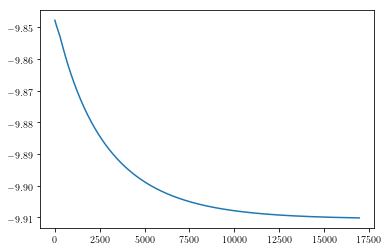

In [154]:
plt.plot(xpr2_12_1)

In [85]:
FP1_111.T[0][184:210]

array([0.6984, 0.6985, 0.6986, 0.6987, 0.6988, 0.6989, 0.699 , 0.6991,
       0.6992, 0.6993, 0.6994, 0.6995, 0.6996, 0.6997, 0.6998, 0.6999,
       0.7   , 0.7001, 0.7002, 0.7003, 0.7004, 0.7005, 0.7006, 0.7007,
       0.7008, 0.7009])

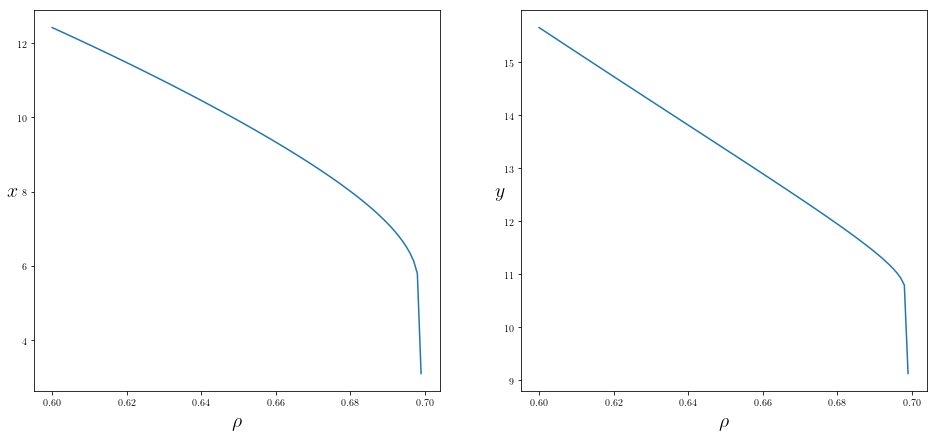

In [44]:
# Plot the FP data in 2d...
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.plot(FP1_11.T[0][:100],FP1_11.T[2][:100])
plt.xlabel(r'$\rho$',fontsize=20)
plt.ylabel(r'$x$',fontsize=20,rotation=0)
plt.subplot(1,2,2)
plt.plot(FP1_11.T[0][:100],FP1_11.T[3][:100])
plt.xlabel(r'$\rho$',fontsize=20)
plt.ylabel(r'$y$',fontsize=20,rotation=0)
plt.show()

In [21]:
# save the FP data for the 3d plot
#savedata('FP1_1',FP1_1[0:91,:])
FP1_1 = loaddata('FP1_1')
print(FP1_1)

# save the limit cycle plot for 3d...
z_values = np.linspace(0.705, 0.78, 50)
#LCdatax = xpr1_1[0:10000]; LCdatay = xpr2_1[0:10000]
#savedata('FP1_LC1x',LCdatax); savedata('FP1_LC1y',LCdatay)
LCdatax = loaddata('FP1_LC1x'); LCdatay = loaddata('FP1_LC1y')

[[ 0.2         0.         37.62842723 55.49402241]
 [ 0.20555556  0.         36.82730829 54.20869003]
 [ 0.21111111  0.         36.04853072 52.94931068]
 [ 0.21666667  0.         35.29136495 51.71662529]
 [ 0.22222222  0.         34.55503764 50.51123353]
 [ 0.22777778  0.         33.83878323 49.33362944]
 [ 0.23333333  0.         33.14188418 48.18422939]
 [ 0.23888889  0.         32.46370023 47.06339228]
 [ 0.24444444  0.         31.80368787 45.97143282]
 [ 0.25        0.         31.16140993 44.90862833]
 [ 0.25555556  0.         30.53653774 43.87521971]
 [ 0.26111111  0.         29.92884495 42.87140826]
 [ 0.26666667  0.         29.33819601 41.89734874]
 [ 0.27222222  0.         28.76452972 40.9531403 ]
 [ 0.27777778  0.         28.20783959 40.03881624]
 [ 0.28333333  0.         27.66815242 39.15433388]
 [ 0.28888889  0.         27.1455066  38.29956535]
 [ 0.29444444  0.         26.63993143 37.47429004]
 [ 0.3         0.         26.15142831 36.67818952]
 [ 0.30555556  0.         25.67

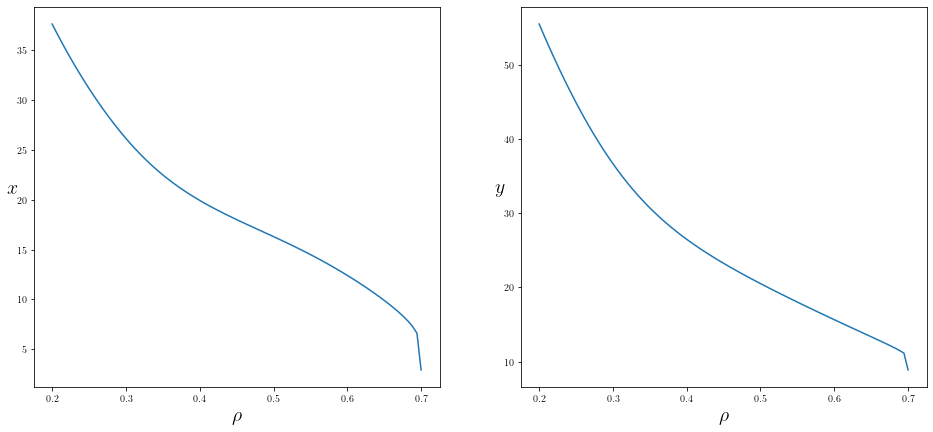

In [22]:
# Plot the FP data in 2d...
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.plot(FP1_1.T[0],FP1_1.T[2])
plt.xlabel(r'$\rho$',fontsize=20)
plt.ylabel(r'$x$',fontsize=20,rotation=0)
plt.subplot(1,2,2)
plt.plot(FP1_1.T[0],FP1_1.T[3])
plt.xlabel(r'$\rho$',fontsize=20)
plt.ylabel(r'$y$',fontsize=20,rotation=0)
plt.show()

### FP for FP2

In [23]:
rho_max=0.745
rho_min=0.73
rho_steps=5
rhospace=np.linspace(rho_min,rho_max,rho_steps)
R2_1=np.empty([rho_steps,N]) 
FP2_1=np.empty([rho_steps,4])
# start from random vec leading to (8.011575394768629,11.948578613390712)
xpr1_2, xpr2_2, rho_2, FP2_1, R2_1 = inspect_from_random_IC_for_multiple_rho_KEEP_GOING(
                                     -rand_vec3,rhospace,Minit,xcen,dt,t_time,
                                     ListenEndTime,TrainEndTime,Win,N,dd1,omega1,
                                     dd2,omega2,gama,sigma,alpha,beta,xy_1,
                                     PredictEndTime,Xcen1,FP_err_lim,R2_1,
                                     FP2_1)

rho=0.73, Xcen=0.0, FP: (-8.174385383873055,7.11293073240974)
rho=0.73375, Xcen=0.0, FP: (-8.0200610570956,6.828574159097916)
rho=0.7375, Xcen=0.0, FP: (-7.839542389661775,6.5009543851293135)
rho=0.74125, Xcen=0.0, FP: (-7.588088137053878,6.052594818926383)
Bifurcation possible: 0.745,0.0,4.0
rho=0.745, Xcen=0.0, FP: (-6.444893975704548,4.772036868878031)
done...


stops tracking at 0.745


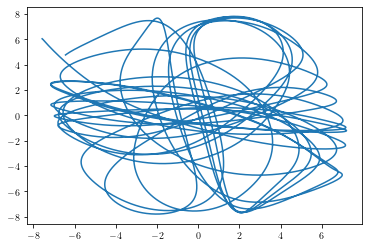

In [24]:
print(f'stops tracking at {rho_2}')
plt.plot(xpr1_2, xpr2_2)

In [25]:
# save the FP data for the 3d plot
#savedata('FP2_1',FP2_1[0:98,:])
FP2_1 = loaddata('FP2_1')
print(FP2_1)

#plt.plot(xpr1_2,xpr2_2)
# save the limit cycle plot for 3d...
#z_values = np.linspace(0.74, 0.779, 50)
#LC2datax = xpr1_2[0:10000]; LC2datay = xpr2_2[0:10000]
#savedata('FP2_LC1x',LC2datax); savedata('FP2_LC1y',LC2datay)
#LC2datax = loaddata('FP2_LC1x'); LC2datay = loaddata('FP2_LC1y')

[[  0.2          0.          31.19580187 -41.71938705]
 [  0.20555556   0.          30.41471273 -41.11609941]
 [  0.21111111   0.          29.64974987 -40.50980531]
 [  0.21666667   0.          28.90079373 -39.9012292 ]
 [  0.22222222   0.          28.1676464  -39.29086632]
 [  0.22777778   0.          27.45008289 -38.67903591]
 [  0.23333333   0.          26.74789345 -38.06593075]
 [  0.23888889   0.          26.06091737 -37.45166267]
 [  0.24444444   0.          25.38906895 -36.83630529]
 [  0.25         0.          24.73235538 -36.2199323 ]
 [  0.25555556   0.          24.09088758 -35.60265169]
 [  0.26111111   0.          23.46488429 -34.9846357 ]
 [  0.26666667   0.          22.85466969 -34.36614516]
 [  0.27222222   0.          22.26066561 -33.74754846]
 [  0.27777778   0.          21.68337865 -33.12933438]
 [  0.28333333   0.          21.12338368 -32.51211831]
 [  0.28888889   0.          20.58130383 -31.89664217]
 [  0.29444444   0.          20.05778855 -31.28376781]
 [  0.3   

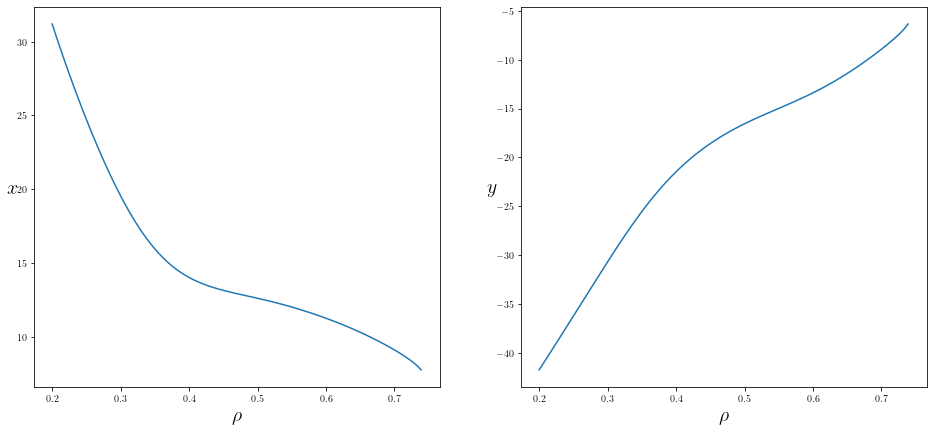

In [26]:
# Plot the FP data in 2d...
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.plot(FP2_1.T[0],FP2_1.T[2])
plt.xlabel(r'$\rho$',fontsize=20)
plt.ylabel(r'$x$',fontsize=20,rotation=0)
plt.subplot(1,2,2)
plt.plot(FP2_1.T[0],FP2_1.T[3])
plt.xlabel(r'$\rho$',fontsize=20)
plt.ylabel(r'$y$',fontsize=20,rotation=0)
plt.show()

### Get circle plots...

In [27]:
# rho_max=1.5
# rho_min=rho_max
# rho_steps=1
# rhospace=np.linspace(rho_min,rho_max,rho_steps)

# x1C1_MF,x2C1_MF,x1C2_MF,x2C2_MF,xy_1,Wout_alpha,M = trainRC_part1(rhospace,Minit,xcen,alpha,dt,
#               t_time,ListenEndTime,TrainEndTime,PredictEndTime,Win,largest_evalue,N,dd1,omega1,dd2,omega2,gama,sigma,beta,
#               FP_err_lim,FP_sample_start,FP_sample_end,LC_err_tol,rounding_no,sample_start,sample_end,stepback,Xcen1,ycen,
#               iter_no,Xcen2)

In [28]:
# plt.plot(x1C1_MF,x2C1_MF)
# plt.plot(x1C1_MF[-10],x2C1_MF[-10],'go')
# plt.plot(x1C1_MF[-1],x2C1_MF[-1],'ro')

# # plt.plot(x1C2_MF,x2C2_MF)
# # plt.plot(x1C2_MF[-10],x2C2_MF[-10],'go')
# # plt.plot(x1C2_MF[-1],x2C2_MF[-1],'ro')

In [29]:
# set up the limit cycle and circle plots for 3d...
z_valuesCA = np.linspace(0.84, 2.08, 50)
z_valuesCB = np.linspace(2.08, 2.5, 50)
#CAdatax = x1C2_MF; CAdatay = x2C1_MF
#savedata('FP1_CA1x',CAdatax); savedata('FP1_CA1y',CAdatay)
CAdatax = loaddata('FP1_CA1x'); CAdatay = loaddata('FP1_CA1y')

#CBdatax = x1C2_MF; CBdatay = x2C2_MF
#savedata('FP1_CB1x',CBdatax); savedata('FP1_CB1y',CBdatay)
CBdatax = loaddata('FP1_CB1x'); CBdatay = loaddata('FP1_CB1y')

#multistability regions...
z_valuesMS = np.linspace(0.77, 0.855, 50)
z_valuesMS2 = np.linspace(1.27, 2.08, 50)
z_valuesMS3 = np.linspace(2.40, 2.46, 50)
r = 1.0  # radius
theta = np.linspace(0, 2*np.pi, 100)  # angles
xMS = r * np.cos(theta)  # x coordinates
yMS = r * np.sin(theta)  # y coordinates

## 3D plot simple...

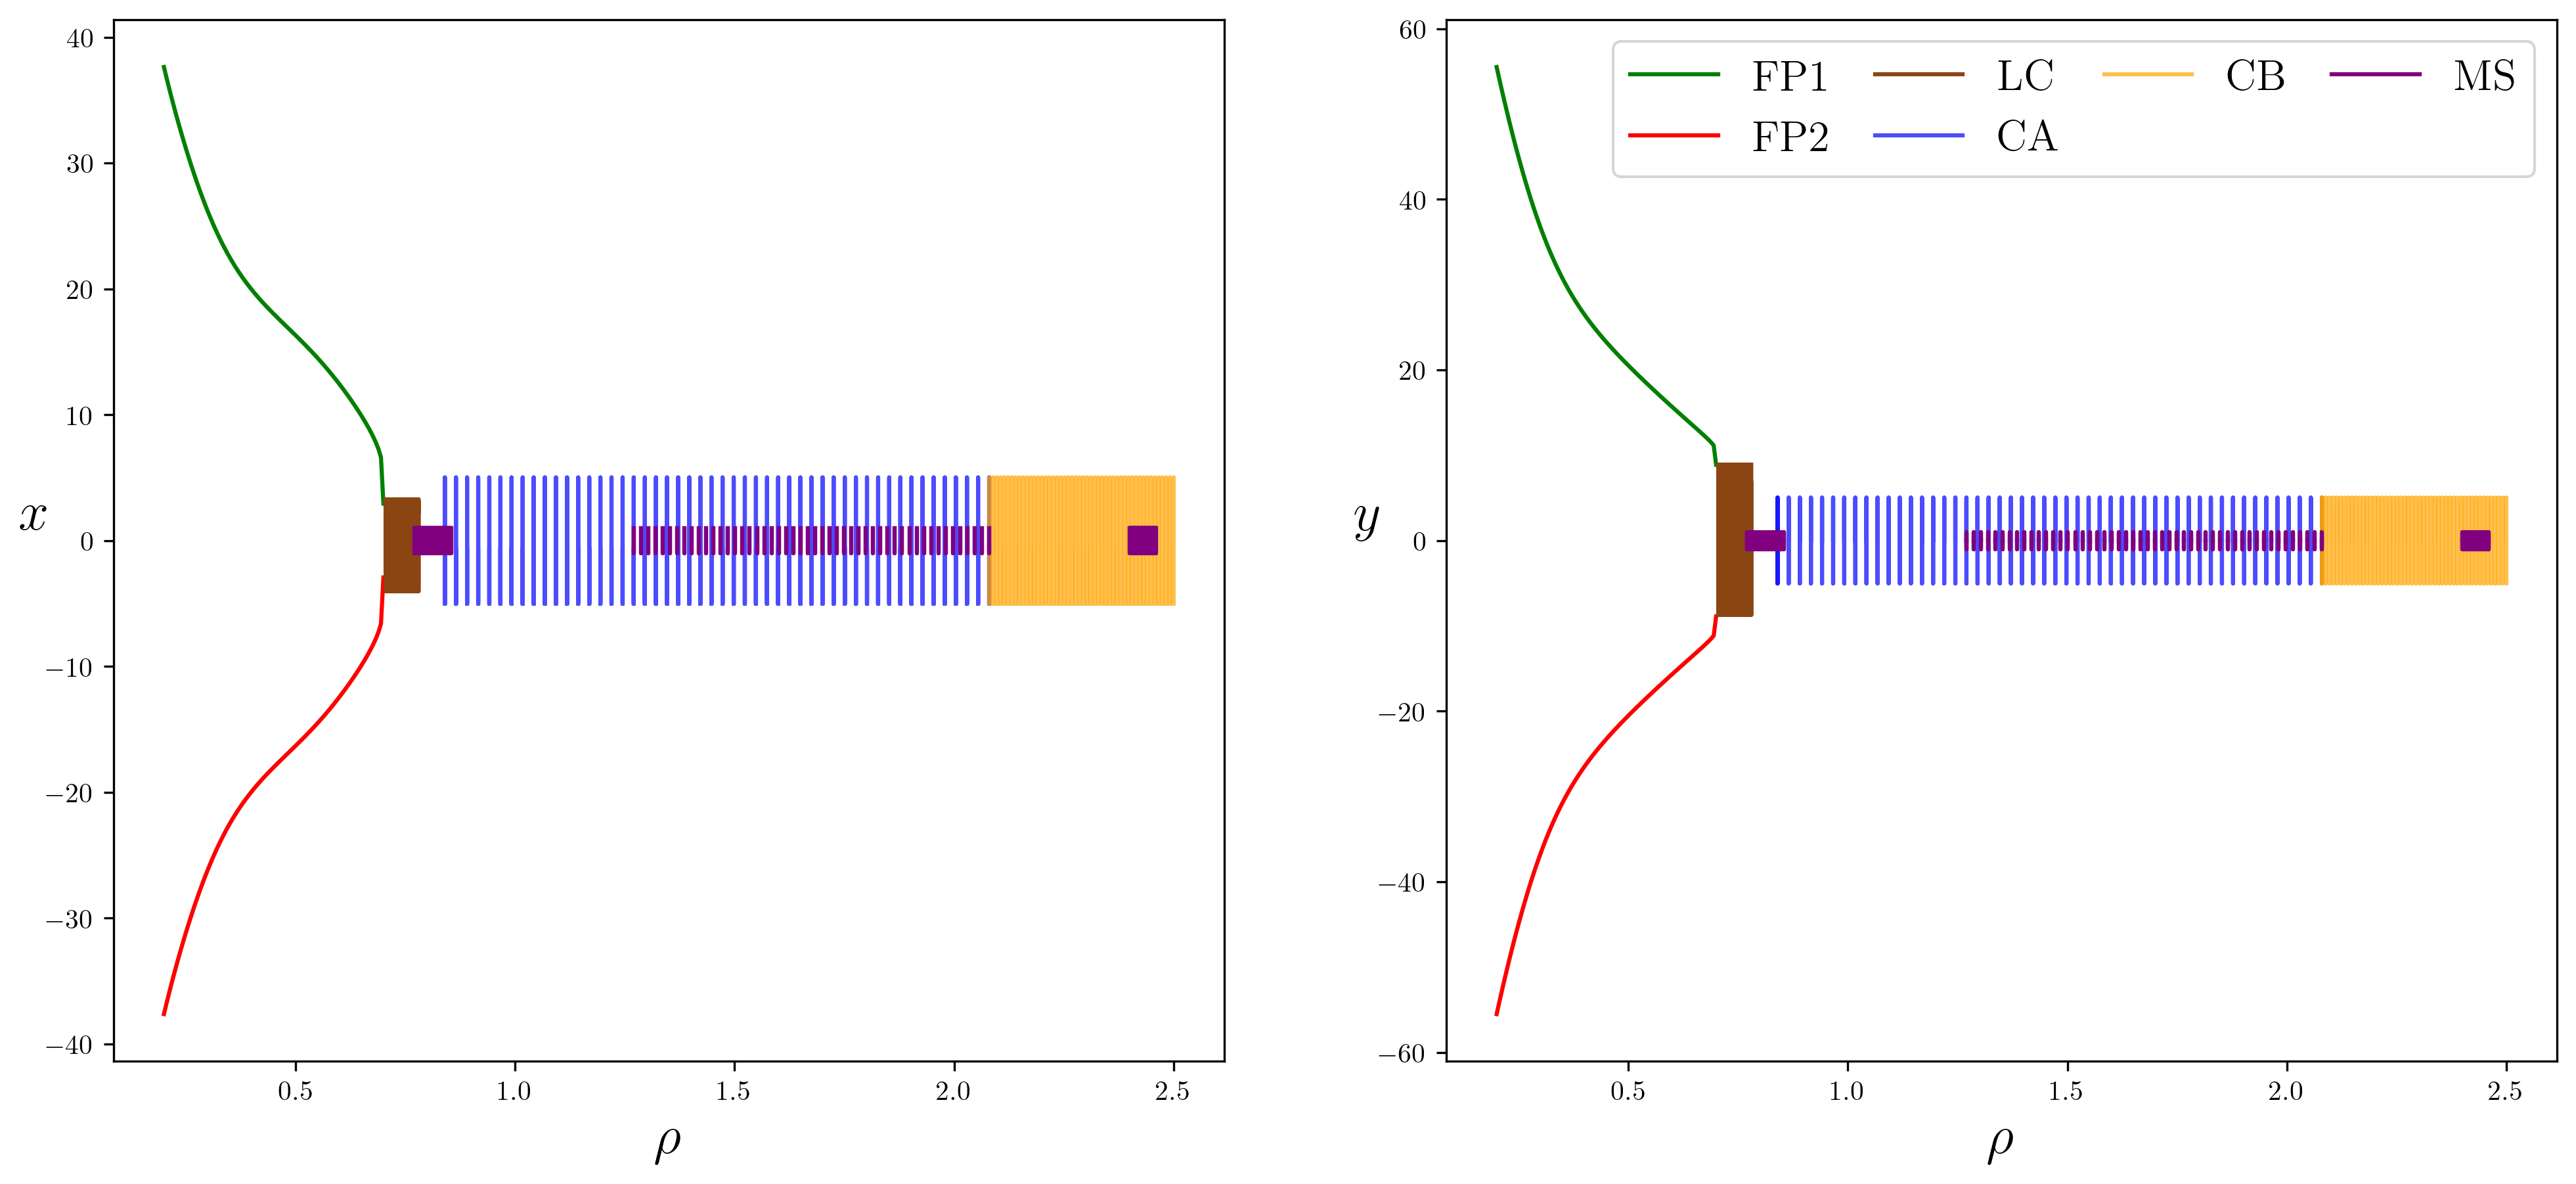

In [30]:
# 2D first...

plt.figure(figsize=(16,7),dpi=300)
plt.subplot(1,2,1)
plt.plot(FP1_1.T[0],FP1_1.T[2],'g')
plt.plot(FP1_1.T[0],-FP1_1.T[2],'r')
for z in z_values:
    plt.plot(z*np.ones_like(LCdatax),LCdatax, 'saddlebrown')
for z in z_valuesCA:
    plt.plot(z*np.ones_like(CAdatax),CAdatax, 'blue', alpha=0.7)
for z in z_valuesCB:
    plt.plot(z*np.ones_like(CBdatax),CBdatax, 'orange', alpha=0.7)
for z in z_valuesMS:
    plt.plot(z*np.ones_like(xMS),xMS, 'purple', alpha=1)
for z in z_valuesMS2:
    plt.plot(z*np.ones_like(xMS),xMS, 'purple', alpha=1)
for z in z_valuesMS3:
    plt.plot(z*np.ones_like(xMS),xMS, 'purple', alpha=1)

#plt.plot(z_values,LCdatax,'saddlebrown')
# plt.plot(LC_data.T[0],-LC_data.T[2],'saddlebrown')
# #plt.plot(LC_data.T[0],LC_data.T[4],'saddlebrown')
# plt.plot(Ca_data.T[0],Ca_data.T[2],'C1')
# plt.plot(Ca_data.T[0],Ca_data.T[4],'C1')
# plt.plot(Cb_data.T[0],Cb_data.T[2],'blue')
# plt.plot(Cb_data.T[0],Cb_data.T[4],'blue')
#plt.plot(LC_data.T[0],LC_data.T[4],'r')
plt.xlabel(r'$\rho$',fontsize=20)
plt.ylabel(r'$x$',fontsize=20,rotation=0)
plt.subplot(1,2,2)
plt.plot(FP1_1.T[0],FP1_1.T[3],'g', label=r'FP1')
plt.plot(FP1_1.T[0],-FP1_1.T[3],'r', label=r'FP2')
for z in enumerate(z_values):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(LCdatay),LCdatay, 'saddlebrown', label='LC')        
    plt.plot(z[1]*np.ones_like(LCdatay),LCdatay, 'saddlebrown')
for z in enumerate(z_valuesCA):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(CAdatay),CAdatay, 'blue', alpha=0.7,label='CA')
    plt.plot(z[1]*np.ones_like(CAdatay),CAdatay, 'blue', alpha=0.7)
for z in enumerate(z_valuesCB):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(CBdatay),CBdatay, 'orange', alpha=0.7,label='CB')
    plt.plot(z[1]*np.ones_like(CBdatay),CBdatay, 'orange', alpha=0.7)
for z in enumerate(z_valuesMS):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(yMS),yMS, 'purple', alpha=1,label='MS')
    plt.plot(z[1]*np.ones_like(yMS),yMS, 'purple', alpha=1)
for z in z_valuesMS2:
    plt.plot(z*np.ones_like(yMS),yMS, 'purple', alpha=1)
for z in z_valuesMS3:
    plt.plot(z*np.ones_like(yMS),yMS, 'purple', alpha=1)
# plt.plot(LC_data.T[0],LC_data.T[3],'saddlebrown', label=r'LC1')
# plt.plot(LC_data.T[0],-LC_data.T[3],'saddlebrown')
# #plt.plot(LC_data.T[0],LC_data.T[5],'saddlebrown')
# plt.plot(Ca_data.T[0],Ca_data.T[3],'C1',label=r'$\mathcal{C}_{A}$')
# plt.plot(Ca_data.T[0],Ca_data.T[5],'C1')
# plt.plot(Cb_data.T[0],Cb_data.T[3],'blue', label=r'$\mathcal{C}_{B}$')
# plt.plot(Cb_data.T[0],Cb_data.T[5],'blue')
plt.xlabel(r'$\rho$',fontsize=20)
plt.ylabel(r'$y$',fontsize=20,rotation=0)
plt.legend(loc='upper right',ncol=4,fontsize=16,handlelength=2,columnspacing=1)
plt.show()

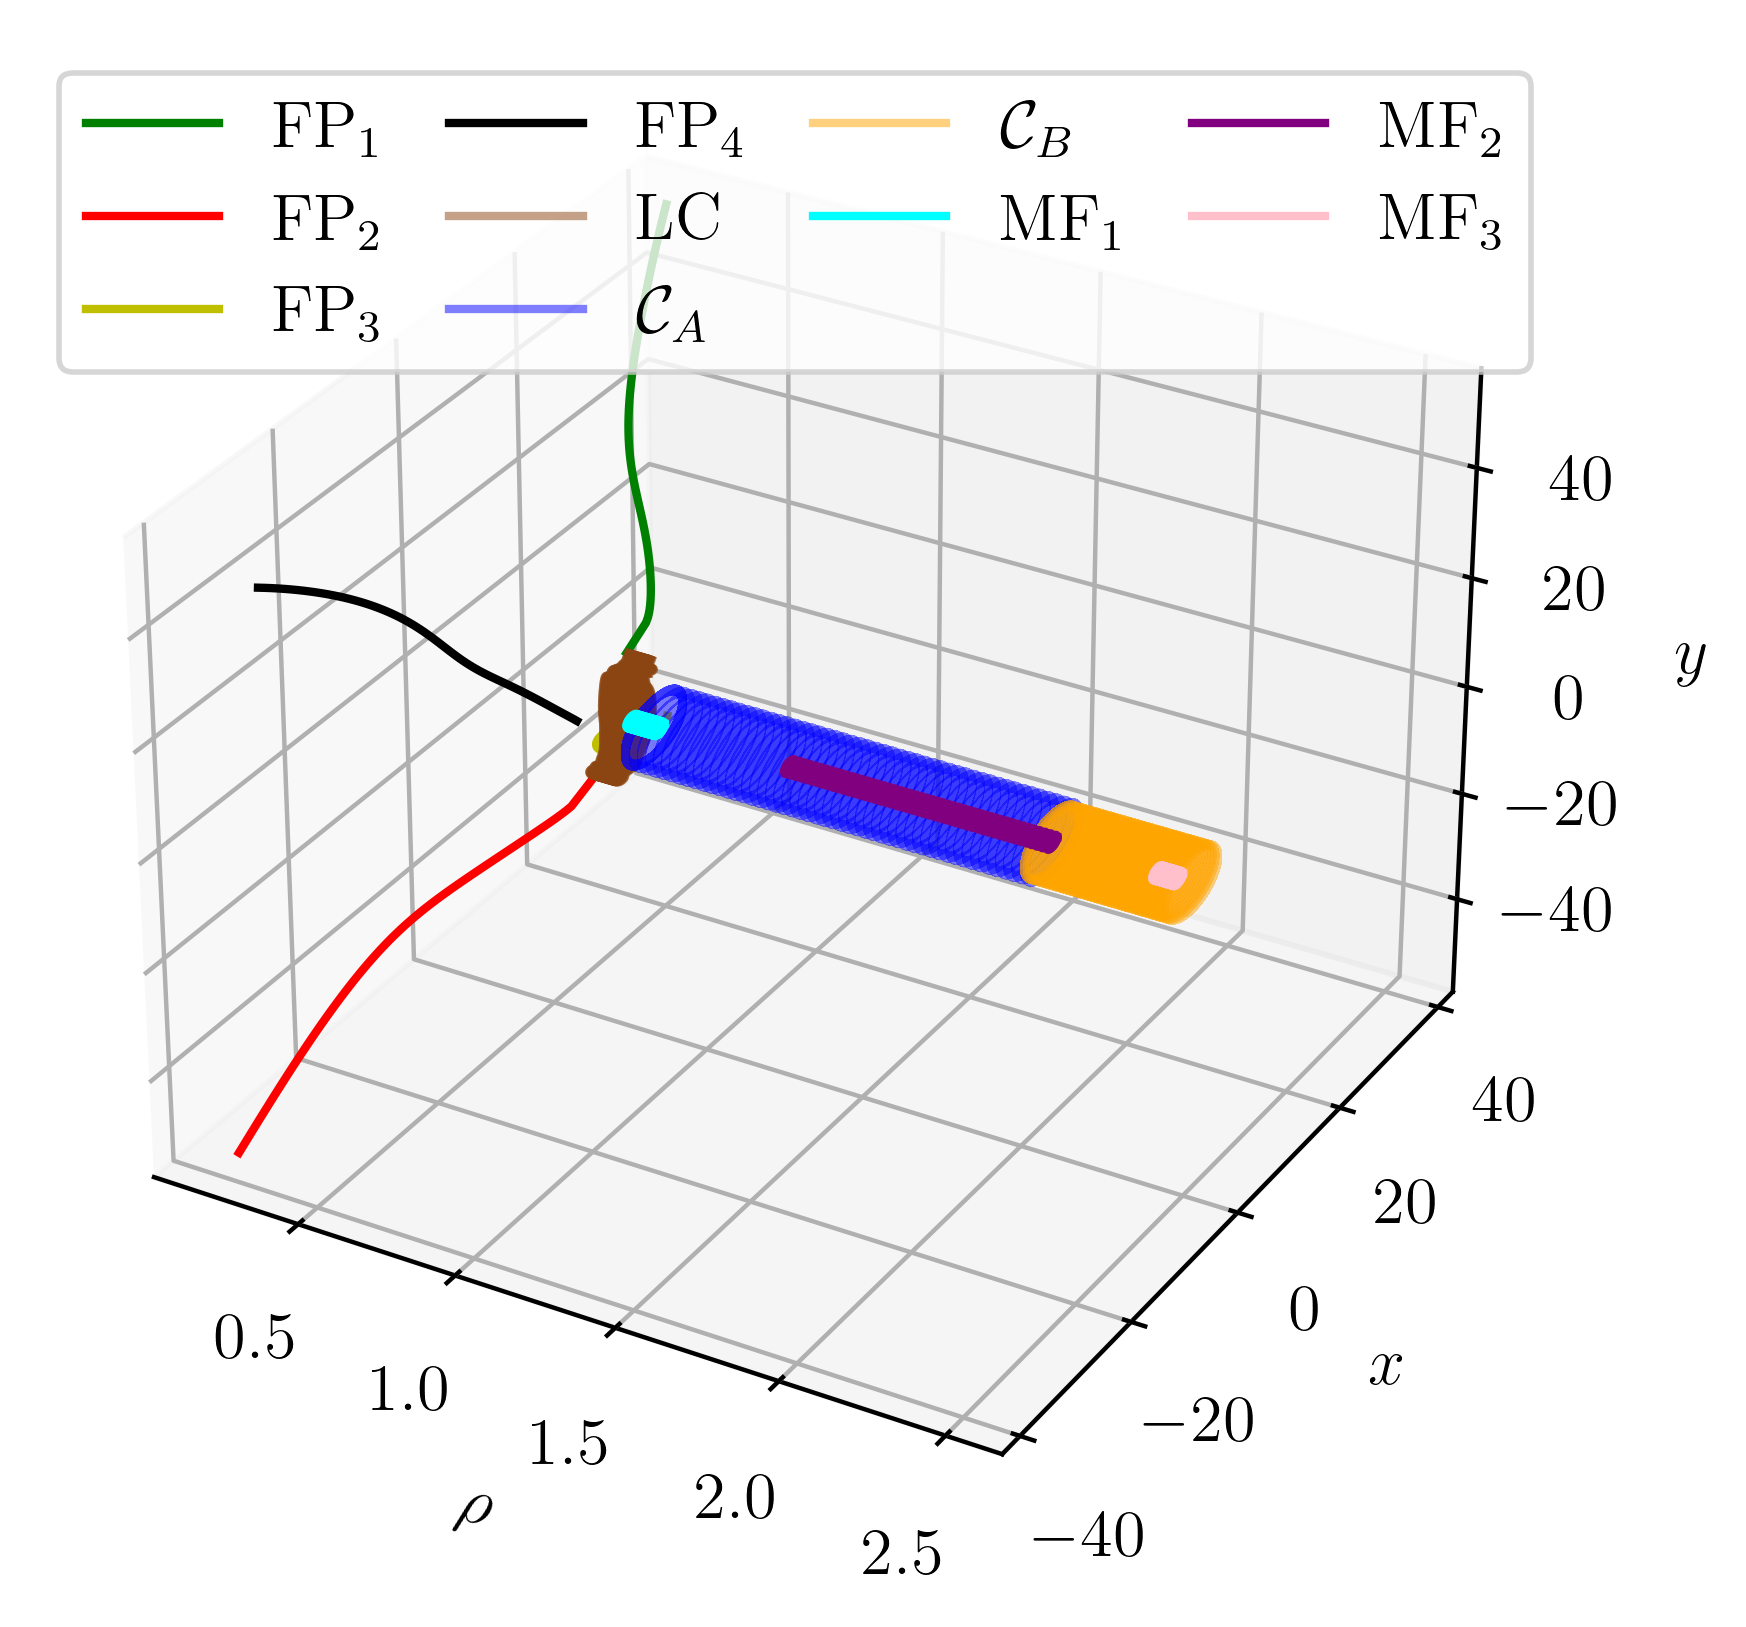

In [31]:
# now 3D...

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D axes object
fig = plt.figure(figsize=(11,5),dpi=400)
ax = fig.add_subplot(111, projection='3d')

# plot in 3d
plt.plot(FP1_1.T[0],FP1_1.T[2],FP1_1.T[3],'g', label=r'FP${}_1$')
plt.plot(FP1_1.T[0],-FP1_1.T[2],-FP1_1.T[3],'r', label=r'FP${}_2$')
plt.plot(FP2_1.T[0],FP2_1.T[2],FP2_1.T[3],'y', label=r'FP${}_3$')
plt.plot(FP2_1.T[0],-FP2_1.T[2],-FP2_1.T[3],'black', label=r'FP${}_4$')

for z in enumerate(z_values):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(LCdatax),LCdatax, LCdatay,alpha=0.5,color='saddlebrown',label='LC')        
    plt.plot(z[1]*np.ones_like(LCdatax),LCdatax,LCdatay, alpha=0.5,color='saddlebrown')
for z in enumerate(z_valuesCA):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(CAdatax),CAdatax,CAdatay, 'blue', alpha=0.5,label=r'$\mathcal{C}_{A}$')
    plt.plot(z[1]*np.ones_like(CAdatax),CAdatax, CAdatay,'blue', alpha=0.5)
for z in enumerate(z_valuesCB):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(CBdatax),CBdatax,CBdatay, 'orange', alpha=0.5,label=r'$\mathcal{C}_{B}$')
    plt.plot(z[1]*np.ones_like(CBdatax),CBdatax, CBdatay,'orange', alpha=0.5)
for z in enumerate(z_valuesMS):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(xMS),xMS,yMS, 'cyan', alpha=1,label='MF${}_1$')
    plt.plot(z[1]*np.ones_like(xMS),xMS, yMS,'cyan', alpha=1)
for z in enumerate(z_valuesMS2):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(xMS),xMS,yMS, 'purple', alpha=1,label=r'MF${}_2$')
    plt.plot(z[1]*np.ones_like(xMS),xMS,yMS, 'purple', alpha=1)
for z in enumerate(z_valuesMS3):
    if(z[0]==0):
        plt.plot(z[1]*np.ones_like(xMS),xMS,yMS, 'pink', alpha=1,label=r'MF${}_3$')
    plt.plot(z[1]*np.ones_like(xMS),xMS,yMS, 'pink', alpha=1)

# Set labels for the axes
ax.set_xlabel(r'$\rho$',fontsize=12)
ax.set_ylabel(r'$x$',fontsize=12)
ax.set_zlabel(r'$y$',fontsize=12)

# Adjust font size of axis ticks
ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(loc='upper center',ncol=4,fontsize=12,handlelength=2,columnspacing=1)

# Show the plot
plt.show()